In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "PAnn"
station_dv = "annual_pr (mm)"
station_path = "data/station_inputs/pr_annual_mean_doy_MSC_25yr_for_maps.csv"
input_model_path = "data/model_inputs/pr_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc"
medians = {"value": 892, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = False


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,annual_pr (mm),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,552,1011,901.0,-4.517790,10.457750,42.0333,-82.9000,191.0,HARROW CDA,ON,932.240845,1.070206
1,553,1007,938.0,-4.474659,10.302673,42.1034,-83.0945,182.0,AMHERSTBURG,ON,942.614868,1.101892
2,553,1015,862.0,-4.477661,10.621608,42.0431,-82.6739,200.0,KINGSVILLE MOE,ON,932.045593,1.024096


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

120.0

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/1367 [00:00<?, ?it/s]

  0%|          | 2/1367 [00:00<08:04,  2.82it/s]

  0%|          | 3/1367 [00:01<10:28,  2.17it/s]

  0%|          | 4/1367 [00:02<11:46,  1.93it/s]

  0%|          | 5/1367 [00:02<12:44,  1.78it/s]

  0%|          | 6/1367 [00:03<13:43,  1.65it/s]

  1%|          | 7/1367 [00:04<14:14,  1.59it/s]

  1%|          | 8/1367 [00:04<14:41,  1.54it/s]

  1%|          | 9/1367 [00:05<15:09,  1.49it/s]

  1%|          | 10/1367 [00:06<15:15,  1.48it/s]

  1%|          | 11/1367 [00:06<15:18,  1.48it/s]

  1%|          | 12/1367 [00:07<15:22,  1.47it/s]

  1%|          | 13/1367 [00:08<15:22,  1.47it/s]

  1%|          | 14/1367 [00:08<15:13,  1.48it/s]

  1%|          | 15/1367 [00:09<15:07,  1.49it/s]

  1%|          | 16/1367 [00:10<15:05,  1.49it/s]

  1%|          | 17/1367 [00:10<15:00,  1.50it/s]

  1%|▏         | 18/1367 [00:11<15:48,  1.42it/s]

  1%|▏         | 19/1367 [00:12<15:55,  1.41it/s]

  1%|▏         | 20/1367 [00:13<15:39,  1.43it/s]

  2%|▏         | 21/1367 [00:13<15:43,  1.43it/s]

  2%|▏         | 22/1367 [00:14<15:49,  1.42it/s]

  2%|▏         | 23/1367 [00:15<15:49,  1.42it/s]

  2%|▏         | 24/1367 [00:15<15:39,  1.43it/s]

  2%|▏         | 25/1367 [00:16<15:38,  1.43it/s]

  2%|▏         | 26/1367 [00:17<15:38,  1.43it/s]

  2%|▏         | 27/1367 [00:17<15:19,  1.46it/s]

  2%|▏         | 28/1367 [00:18<15:19,  1.46it/s]

  2%|▏         | 29/1367 [00:19<15:08,  1.47it/s]

  2%|▏         | 30/1367 [00:20<15:15,  1.46it/s]

  2%|▏         | 31/1367 [00:20<15:08,  1.47it/s]

  2%|▏         | 32/1367 [00:21<14:58,  1.49it/s]

  2%|▏         | 33/1367 [00:22<15:02,  1.48it/s]

  2%|▏         | 34/1367 [00:22<15:04,  1.47it/s]

  3%|▎         | 35/1367 [00:23<14:57,  1.48it/s]

  3%|▎         | 36/1367 [00:24<14:59,  1.48it/s]

  3%|▎         | 37/1367 [00:24<14:52,  1.49it/s]

  3%|▎         | 38/1367 [00:25<15:12,  1.46it/s]

  3%|▎         | 39/1367 [00:26<15:11,  1.46it/s]

  3%|▎         | 40/1367 [00:26<15:23,  1.44it/s]

  3%|▎         | 41/1367 [00:27<15:14,  1.45it/s]

  3%|▎         | 42/1367 [00:28<15:17,  1.44it/s]

  3%|▎         | 43/1367 [00:28<15:30,  1.42it/s]

  3%|▎         | 44/1367 [00:29<15:27,  1.43it/s]

  3%|▎         | 45/1367 [00:30<15:41,  1.40it/s]

  3%|▎         | 46/1367 [00:31<15:36,  1.41it/s]

  3%|▎         | 47/1367 [00:31<15:18,  1.44it/s]

  4%|▎         | 48/1367 [00:32<15:11,  1.45it/s]

  4%|▎         | 49/1367 [00:33<15:04,  1.46it/s]

  4%|▎         | 50/1367 [00:33<15:07,  1.45it/s]

  4%|▎         | 51/1367 [00:34<15:21,  1.43it/s]

  4%|▍         | 52/1367 [00:35<15:00,  1.46it/s]

  4%|▍         | 53/1367 [00:35<14:59,  1.46it/s]

  4%|▍         | 54/1367 [00:36<15:05,  1.45it/s]

  4%|▍         | 55/1367 [00:37<15:12,  1.44it/s]

  4%|▍         | 56/1367 [00:37<15:07,  1.45it/s]

  4%|▍         | 57/1367 [00:38<14:59,  1.46it/s]

  4%|▍         | 58/1367 [00:39<15:11,  1.44it/s]

  4%|▍         | 59/1367 [00:40<15:07,  1.44it/s]

  4%|▍         | 60/1367 [00:40<15:01,  1.45it/s]

  4%|▍         | 61/1367 [00:41<15:11,  1.43it/s]

  5%|▍         | 62/1367 [00:42<15:09,  1.44it/s]

  5%|▍         | 63/1367 [00:42<15:04,  1.44it/s]

  5%|▍         | 64/1367 [00:43<15:06,  1.44it/s]

  5%|▍         | 65/1367 [00:44<15:06,  1.44it/s]

  5%|▍         | 66/1367 [00:44<15:06,  1.44it/s]

  5%|▍         | 67/1367 [00:45<15:09,  1.43it/s]

  5%|▍         | 68/1367 [00:46<14:58,  1.45it/s]

  5%|▌         | 69/1367 [00:46<14:56,  1.45it/s]

  5%|▌         | 70/1367 [00:47<14:51,  1.46it/s]

  5%|▌         | 71/1367 [00:48<15:10,  1.42it/s]

  5%|▌         | 72/1367 [00:49<15:29,  1.39it/s]

  5%|▌         | 73/1367 [00:49<15:04,  1.43it/s]

  5%|▌         | 74/1367 [00:50<15:16,  1.41it/s]

  5%|▌         | 75/1367 [00:51<15:20,  1.40it/s]

  6%|▌         | 76/1367 [00:51<15:18,  1.41it/s]

  6%|▌         | 77/1367 [00:52<16:01,  1.34it/s]

  6%|▌         | 78/1367 [00:53<15:40,  1.37it/s]

  6%|▌         | 79/1367 [00:54<15:22,  1.40it/s]

  6%|▌         | 80/1367 [00:54<15:11,  1.41it/s]

  6%|▌         | 81/1367 [00:55<15:20,  1.40it/s]

  6%|▌         | 82/1367 [00:56<15:01,  1.43it/s]

  6%|▌         | 83/1367 [00:56<14:53,  1.44it/s]

  6%|▌         | 84/1367 [00:57<14:55,  1.43it/s]

  6%|▌         | 85/1367 [00:58<14:49,  1.44it/s]

  6%|▋         | 86/1367 [00:59<14:48,  1.44it/s]

  6%|▋         | 87/1367 [00:59<14:30,  1.47it/s]

  6%|▋         | 88/1367 [01:00<14:23,  1.48it/s]

  7%|▋         | 89/1367 [01:01<14:27,  1.47it/s]

  7%|▋         | 90/1367 [01:01<14:21,  1.48it/s]

  7%|▋         | 91/1367 [01:02<14:22,  1.48it/s]

  7%|▋         | 92/1367 [01:03<14:40,  1.45it/s]

  7%|▋         | 93/1367 [01:03<14:35,  1.46it/s]

  7%|▋         | 94/1367 [01:04<14:31,  1.46it/s]

  7%|▋         | 95/1367 [01:05<14:39,  1.45it/s]

  7%|▋         | 96/1367 [01:05<14:46,  1.43it/s]

  7%|▋         | 97/1367 [01:06<14:55,  1.42it/s]

  7%|▋         | 98/1367 [01:07<14:45,  1.43it/s]

  7%|▋         | 99/1367 [01:07<14:43,  1.44it/s]

  7%|▋         | 100/1367 [01:08<14:48,  1.43it/s]

  7%|▋         | 101/1367 [01:09<14:37,  1.44it/s]

  7%|▋         | 102/1367 [01:10<14:37,  1.44it/s]

  8%|▊         | 103/1367 [01:10<14:31,  1.45it/s]

  8%|▊         | 104/1367 [01:11<14:23,  1.46it/s]

  8%|▊         | 105/1367 [01:12<14:35,  1.44it/s]

  8%|▊         | 106/1367 [01:12<14:31,  1.45it/s]

  8%|▊         | 107/1367 [01:13<14:17,  1.47it/s]

  8%|▊         | 108/1367 [01:14<14:11,  1.48it/s]

  8%|▊         | 109/1367 [01:14<14:12,  1.48it/s]

  8%|▊         | 110/1367 [01:15<14:09,  1.48it/s]

  8%|▊         | 111/1367 [01:16<14:22,  1.46it/s]

  8%|▊         | 112/1367 [01:16<14:16,  1.47it/s]

  8%|▊         | 113/1367 [01:17<14:17,  1.46it/s]

  8%|▊         | 114/1367 [01:18<14:12,  1.47it/s]

  8%|▊         | 115/1367 [01:18<14:10,  1.47it/s]

  8%|▊         | 116/1367 [01:19<14:08,  1.47it/s]

  9%|▊         | 117/1367 [01:20<14:42,  1.42it/s]

  9%|▊         | 118/1367 [01:21<14:43,  1.41it/s]

  9%|▊         | 119/1367 [01:21<14:39,  1.42it/s]

  9%|▉         | 120/1367 [01:22<14:56,  1.39it/s]

  9%|▉         | 121/1367 [01:23<14:38,  1.42it/s]

  9%|▉         | 122/1367 [01:23<14:32,  1.43it/s]

  9%|▉         | 123/1367 [01:24<14:45,  1.40it/s]

  9%|▉         | 124/1367 [01:25<14:31,  1.43it/s]

  9%|▉         | 125/1367 [01:25<14:32,  1.42it/s]

  9%|▉         | 126/1367 [01:26<14:27,  1.43it/s]

  9%|▉         | 127/1367 [01:27<14:20,  1.44it/s]

  9%|▉         | 128/1367 [01:28<14:06,  1.46it/s]

  9%|▉         | 129/1367 [01:28<14:02,  1.47it/s]

 10%|▉         | 130/1367 [01:29<14:02,  1.47it/s]

 10%|▉         | 131/1367 [01:30<14:01,  1.47it/s]

 10%|▉         | 132/1367 [01:30<14:01,  1.47it/s]

 10%|▉         | 133/1367 [01:31<14:08,  1.45it/s]

 10%|▉         | 134/1367 [01:32<14:13,  1.44it/s]

 10%|▉         | 135/1367 [01:32<14:09,  1.45it/s]

 10%|▉         | 136/1367 [01:33<14:01,  1.46it/s]

 10%|█         | 137/1367 [01:34<13:49,  1.48it/s]

 10%|█         | 138/1367 [01:34<13:51,  1.48it/s]

 10%|█         | 139/1367 [01:35<13:55,  1.47it/s]

 10%|█         | 140/1367 [01:36<14:02,  1.46it/s]

 10%|█         | 141/1367 [01:36<14:20,  1.42it/s]

 10%|█         | 142/1367 [01:37<14:13,  1.44it/s]

 10%|█         | 143/1367 [01:38<14:07,  1.44it/s]

 11%|█         | 144/1367 [01:39<14:08,  1.44it/s]

 11%|█         | 145/1367 [01:39<14:13,  1.43it/s]

 11%|█         | 146/1367 [01:40<13:58,  1.46it/s]

 11%|█         | 147/1367 [01:41<14:36,  1.39it/s]

 11%|█         | 148/1367 [01:41<14:35,  1.39it/s]

 11%|█         | 149/1367 [01:42<14:05,  1.44it/s]

 11%|█         | 150/1367 [01:43<13:54,  1.46it/s]

 11%|█         | 151/1367 [01:43<13:48,  1.47it/s]

 11%|█         | 152/1367 [01:44<13:45,  1.47it/s]

 11%|█         | 153/1367 [01:45<13:48,  1.47it/s]

 11%|█▏        | 154/1367 [01:45<13:48,  1.46it/s]

 11%|█▏        | 155/1367 [01:46<14:01,  1.44it/s]

 11%|█▏        | 156/1367 [01:47<13:41,  1.47it/s]

 11%|█▏        | 157/1367 [01:47<13:38,  1.48it/s]

 12%|█▏        | 158/1367 [01:48<13:24,  1.50it/s]

 12%|█▏        | 159/1367 [01:49<13:16,  1.52it/s]

 12%|█▏        | 160/1367 [01:49<13:03,  1.54it/s]

 12%|█▏        | 161/1367 [01:50<12:54,  1.56it/s]

 12%|█▏        | 162/1367 [01:51<13:07,  1.53it/s]

 12%|█▏        | 163/1367 [01:51<13:15,  1.51it/s]

 12%|█▏        | 164/1367 [01:52<13:30,  1.48it/s]

 12%|█▏        | 165/1367 [01:53<13:06,  1.53it/s]

 12%|█▏        | 166/1367 [01:53<13:23,  1.49it/s]

 12%|█▏        | 167/1367 [01:54<13:48,  1.45it/s]

 12%|█▏        | 168/1367 [01:55<14:02,  1.42it/s]

 12%|█▏        | 169/1367 [01:56<13:57,  1.43it/s]

 12%|█▏        | 170/1367 [01:56<13:33,  1.47it/s]

 13%|█▎        | 171/1367 [01:57<13:05,  1.52it/s]

 13%|█▎        | 172/1367 [01:58<13:32,  1.47it/s]

 13%|█▎        | 173/1367 [01:58<13:33,  1.47it/s]

 13%|█▎        | 174/1367 [01:59<13:36,  1.46it/s]

 13%|█▎        | 175/1367 [02:00<13:44,  1.45it/s]

 13%|█▎        | 176/1367 [02:00<13:17,  1.49it/s]

 13%|█▎        | 177/1367 [02:01<13:09,  1.51it/s]

 13%|█▎        | 178/1367 [02:02<13:18,  1.49it/s]

 13%|█▎        | 179/1367 [02:02<13:33,  1.46it/s]

 13%|█▎        | 180/1367 [02:03<13:42,  1.44it/s]

 13%|█▎        | 181/1367 [02:04<13:25,  1.47it/s]

 13%|█▎        | 182/1367 [02:04<13:13,  1.49it/s]

 13%|█▎        | 183/1367 [02:05<12:59,  1.52it/s]

 13%|█▎        | 184/1367 [02:06<13:34,  1.45it/s]

 14%|█▎        | 185/1367 [02:06<13:23,  1.47it/s]

 14%|█▎        | 186/1367 [02:07<13:01,  1.51it/s]

 14%|█▎        | 187/1367 [02:08<13:15,  1.48it/s]

 14%|█▍        | 188/1367 [02:08<13:13,  1.49it/s]

 14%|█▍        | 189/1367 [02:09<13:15,  1.48it/s]

 14%|█▍        | 190/1367 [02:10<13:20,  1.47it/s]

 14%|█▍        | 191/1367 [02:10<13:48,  1.42it/s]

 14%|█▍        | 192/1367 [02:11<13:51,  1.41it/s]

 14%|█▍        | 193/1367 [02:12<14:12,  1.38it/s]

 14%|█▍        | 194/1367 [02:13<14:02,  1.39it/s]

 14%|█▍        | 195/1367 [02:13<14:09,  1.38it/s]

 14%|█▍        | 196/1367 [02:14<13:47,  1.41it/s]

 14%|█▍        | 197/1367 [02:15<13:09,  1.48it/s]

 14%|█▍        | 198/1367 [02:15<12:55,  1.51it/s]

 15%|█▍        | 199/1367 [02:16<13:30,  1.44it/s]

 15%|█▍        | 200/1367 [02:17<13:29,  1.44it/s]

 15%|█▍        | 201/1367 [02:17<13:13,  1.47it/s]

 15%|█▍        | 202/1367 [02:18<13:12,  1.47it/s]

 15%|█▍        | 203/1367 [02:19<12:54,  1.50it/s]

 15%|█▍        | 204/1367 [02:19<13:10,  1.47it/s]

 15%|█▍        | 205/1367 [02:20<13:31,  1.43it/s]

 15%|█▌        | 206/1367 [02:21<13:20,  1.45it/s]

 15%|█▌        | 207/1367 [02:21<13:16,  1.46it/s]

 15%|█▌        | 208/1367 [02:22<14:03,  1.37it/s]

 15%|█▌        | 209/1367 [02:23<13:51,  1.39it/s]

 15%|█▌        | 210/1367 [02:24<14:03,  1.37it/s]

 15%|█▌        | 211/1367 [02:24<13:53,  1.39it/s]

 16%|█▌        | 212/1367 [02:25<13:32,  1.42it/s]

 16%|█▌        | 213/1367 [02:26<14:02,  1.37it/s]

 16%|█▌        | 214/1367 [02:27<14:01,  1.37it/s]

 16%|█▌        | 215/1367 [02:27<14:14,  1.35it/s]

 16%|█▌        | 216/1367 [02:28<14:22,  1.34it/s]

 16%|█▌        | 217/1367 [02:29<14:33,  1.32it/s]

 16%|█▌        | 218/1367 [02:30<14:38,  1.31it/s]

 16%|█▌        | 219/1367 [02:31<14:50,  1.29it/s]

 16%|█▌        | 220/1367 [02:31<14:48,  1.29it/s]

 16%|█▌        | 221/1367 [02:32<14:39,  1.30it/s]

 16%|█▌        | 222/1367 [02:33<14:36,  1.31it/s]

 16%|█▋        | 223/1367 [02:34<14:08,  1.35it/s]

 16%|█▋        | 224/1367 [02:34<13:55,  1.37it/s]

 16%|█▋        | 225/1367 [02:35<13:25,  1.42it/s]

 17%|█▋        | 226/1367 [02:36<13:18,  1.43it/s]

 17%|█▋        | 227/1367 [02:36<13:17,  1.43it/s]

 17%|█▋        | 228/1367 [02:37<13:12,  1.44it/s]

 17%|█▋        | 229/1367 [02:38<13:43,  1.38it/s]

 17%|█▋        | 230/1367 [02:38<13:35,  1.40it/s]

 17%|█▋        | 231/1367 [02:39<13:37,  1.39it/s]

 17%|█▋        | 232/1367 [02:40<13:19,  1.42it/s]

 17%|█▋        | 233/1367 [02:40<12:46,  1.48it/s]

 17%|█▋        | 234/1367 [02:41<12:52,  1.47it/s]

 17%|█▋        | 235/1367 [02:42<12:41,  1.49it/s]

 17%|█▋        | 236/1367 [02:43<13:04,  1.44it/s]

 17%|█▋        | 237/1367 [02:43<13:11,  1.43it/s]

 17%|█▋        | 238/1367 [02:44<13:09,  1.43it/s]

 17%|█▋        | 239/1367 [02:45<13:10,  1.43it/s]

 18%|█▊        | 240/1367 [02:45<13:02,  1.44it/s]

 18%|█▊        | 241/1367 [02:46<12:52,  1.46it/s]

 18%|█▊        | 242/1367 [02:47<12:50,  1.46it/s]

 18%|█▊        | 243/1367 [02:47<12:54,  1.45it/s]

 18%|█▊        | 244/1367 [02:48<12:50,  1.46it/s]

 18%|█▊        | 245/1367 [02:49<12:51,  1.45it/s]

 18%|█▊        | 246/1367 [02:49<12:36,  1.48it/s]

 18%|█▊        | 247/1367 [02:50<13:09,  1.42it/s]

 18%|█▊        | 248/1367 [02:51<13:07,  1.42it/s]

 18%|█▊        | 249/1367 [02:52<12:56,  1.44it/s]

 18%|█▊        | 250/1367 [02:52<13:09,  1.42it/s]

 18%|█▊        | 251/1367 [02:53<13:05,  1.42it/s]

 18%|█▊        | 252/1367 [02:54<13:24,  1.39it/s]

 19%|█▊        | 253/1367 [02:54<13:23,  1.39it/s]

 19%|█▊        | 254/1367 [02:55<13:24,  1.38it/s]

 19%|█▊        | 255/1367 [02:56<12:59,  1.43it/s]

 19%|█▊        | 256/1367 [02:57<13:10,  1.41it/s]

 19%|█▉        | 257/1367 [02:57<12:53,  1.44it/s]

 19%|█▉        | 258/1367 [02:58<12:29,  1.48it/s]

 19%|█▉        | 259/1367 [02:59<12:41,  1.46it/s]

 19%|█▉        | 260/1367 [02:59<12:41,  1.45it/s]

 19%|█▉        | 261/1367 [03:00<12:31,  1.47it/s]

 19%|█▉        | 262/1367 [03:01<12:45,  1.44it/s]

 19%|█▉        | 263/1367 [03:01<12:25,  1.48it/s]

 19%|█▉        | 264/1367 [03:02<12:38,  1.45it/s]

 19%|█▉        | 265/1367 [03:03<12:24,  1.48it/s]

 19%|█▉        | 266/1367 [03:03<12:52,  1.43it/s]

 20%|█▉        | 267/1367 [03:04<12:52,  1.42it/s]

 20%|█▉        | 268/1367 [03:05<12:57,  1.41it/s]

 20%|█▉        | 269/1367 [03:05<12:40,  1.44it/s]

 20%|█▉        | 270/1367 [03:06<12:13,  1.50it/s]

 20%|█▉        | 271/1367 [03:07<12:17,  1.49it/s]

 20%|█▉        | 272/1367 [03:07<12:18,  1.48it/s]

 20%|█▉        | 273/1367 [03:08<12:06,  1.51it/s]

 20%|██        | 274/1367 [03:09<12:06,  1.50it/s]

 20%|██        | 275/1367 [03:09<12:17,  1.48it/s]

 20%|██        | 276/1367 [03:10<12:40,  1.43it/s]

 20%|██        | 277/1367 [03:11<12:27,  1.46it/s]

 20%|██        | 278/1367 [03:12<12:19,  1.47it/s]

 20%|██        | 279/1367 [03:12<12:04,  1.50it/s]

 20%|██        | 280/1367 [03:13<11:50,  1.53it/s]

 21%|██        | 281/1367 [03:13<11:57,  1.51it/s]

 21%|██        | 282/1367 [03:14<12:05,  1.49it/s]

 21%|██        | 283/1367 [03:15<11:53,  1.52it/s]

 21%|██        | 284/1367 [03:15<11:58,  1.51it/s]

 21%|██        | 285/1367 [03:16<12:00,  1.50it/s]

 21%|██        | 286/1367 [03:17<12:05,  1.49it/s]

 21%|██        | 287/1367 [03:18<12:15,  1.47it/s]

 21%|██        | 288/1367 [03:18<11:44,  1.53it/s]

 21%|██        | 289/1367 [03:19<11:38,  1.54it/s]

 21%|██        | 290/1367 [03:19<11:42,  1.53it/s]

 21%|██▏       | 291/1367 [03:20<11:35,  1.55it/s]

 21%|██▏       | 292/1367 [03:21<11:40,  1.53it/s]

 21%|██▏       | 293/1367 [03:21<11:32,  1.55it/s]

 22%|██▏       | 294/1367 [03:22<11:34,  1.54it/s]

 22%|██▏       | 295/1367 [03:23<11:43,  1.52it/s]

 22%|██▏       | 296/1367 [03:23<11:47,  1.51it/s]

 22%|██▏       | 297/1367 [03:24<11:43,  1.52it/s]

 22%|██▏       | 298/1367 [03:25<11:39,  1.53it/s]

 22%|██▏       | 299/1367 [03:25<11:33,  1.54it/s]

 22%|██▏       | 300/1367 [03:26<11:29,  1.55it/s]

 22%|██▏       | 301/1367 [03:27<11:41,  1.52it/s]

 22%|██▏       | 302/1367 [03:27<11:40,  1.52it/s]

 22%|██▏       | 303/1367 [03:28<11:42,  1.52it/s]

 22%|██▏       | 304/1367 [03:29<11:32,  1.53it/s]

 22%|██▏       | 305/1367 [03:29<11:41,  1.51it/s]

 22%|██▏       | 306/1367 [03:30<11:36,  1.52it/s]

 22%|██▏       | 307/1367 [03:31<11:29,  1.54it/s]

 23%|██▎       | 308/1367 [03:31<11:22,  1.55it/s]

 23%|██▎       | 309/1367 [03:32<11:32,  1.53it/s]

 23%|██▎       | 310/1367 [03:33<12:08,  1.45it/s]

 23%|██▎       | 311/1367 [03:33<12:27,  1.41it/s]

 23%|██▎       | 312/1367 [03:34<12:10,  1.44it/s]

 23%|██▎       | 313/1367 [03:35<12:34,  1.40it/s]

 23%|██▎       | 314/1367 [03:35<12:03,  1.46it/s]

 23%|██▎       | 315/1367 [03:36<12:11,  1.44it/s]

 23%|██▎       | 316/1367 [03:37<11:54,  1.47it/s]

 23%|██▎       | 317/1367 [03:38<12:27,  1.41it/s]

 23%|██▎       | 318/1367 [03:38<12:02,  1.45it/s]

 23%|██▎       | 319/1367 [03:39<12:04,  1.45it/s]

 23%|██▎       | 320/1367 [03:40<12:08,  1.44it/s]

 23%|██▎       | 321/1367 [03:40<11:52,  1.47it/s]

 24%|██▎       | 322/1367 [03:41<11:43,  1.49it/s]

 24%|██▎       | 323/1367 [03:42<11:54,  1.46it/s]

 24%|██▎       | 324/1367 [03:42<12:04,  1.44it/s]

 24%|██▍       | 325/1367 [03:43<12:01,  1.44it/s]

 24%|██▍       | 326/1367 [03:44<11:24,  1.52it/s]

 24%|██▍       | 327/1367 [03:44<11:35,  1.49it/s]

 24%|██▍       | 328/1367 [03:45<11:37,  1.49it/s]

 24%|██▍       | 329/1367 [03:46<11:44,  1.47it/s]

 24%|██▍       | 330/1367 [03:46<11:58,  1.44it/s]

 24%|██▍       | 331/1367 [03:47<11:35,  1.49it/s]

 24%|██▍       | 332/1367 [03:48<11:52,  1.45it/s]

 24%|██▍       | 333/1367 [03:48<11:45,  1.47it/s]

 24%|██▍       | 334/1367 [03:49<11:46,  1.46it/s]

 25%|██▍       | 335/1367 [03:50<11:56,  1.44it/s]

 25%|██▍       | 336/1367 [03:51<12:16,  1.40it/s]

 25%|██▍       | 337/1367 [03:51<12:10,  1.41it/s]

 25%|██▍       | 338/1367 [03:52<11:41,  1.47it/s]

 25%|██▍       | 339/1367 [03:53<11:35,  1.48it/s]

 25%|██▍       | 340/1367 [03:53<12:02,  1.42it/s]

 25%|██▍       | 341/1367 [03:54<12:08,  1.41it/s]

 25%|██▌       | 342/1367 [03:55<11:51,  1.44it/s]

 25%|██▌       | 343/1367 [03:55<11:59,  1.42it/s]

 25%|██▌       | 344/1367 [03:56<11:46,  1.45it/s]

 25%|██▌       | 345/1367 [03:57<12:11,  1.40it/s]

 25%|██▌       | 346/1367 [03:57<11:52,  1.43it/s]

 25%|██▌       | 347/1367 [03:58<11:53,  1.43it/s]

 25%|██▌       | 348/1367 [03:59<11:47,  1.44it/s]

 26%|██▌       | 349/1367 [04:00<11:49,  1.43it/s]

 26%|██▌       | 350/1367 [04:00<11:51,  1.43it/s]

 26%|██▌       | 351/1367 [04:01<11:58,  1.41it/s]

 26%|██▌       | 352/1367 [04:02<11:53,  1.42it/s]

 26%|██▌       | 353/1367 [04:02<11:37,  1.45it/s]

 26%|██▌       | 354/1367 [04:03<11:31,  1.46it/s]

 26%|██▌       | 355/1367 [04:04<11:29,  1.47it/s]

 26%|██▌       | 356/1367 [04:04<11:18,  1.49it/s]

 26%|██▌       | 357/1367 [04:05<11:10,  1.51it/s]

 26%|██▌       | 358/1367 [04:06<11:14,  1.50it/s]

 26%|██▋       | 359/1367 [04:06<11:29,  1.46it/s]

 26%|██▋       | 360/1367 [04:07<11:26,  1.47it/s]

 26%|██▋       | 361/1367 [04:08<11:22,  1.47it/s]

 26%|██▋       | 362/1367 [04:08<11:08,  1.50it/s]

 27%|██▋       | 363/1367 [04:09<11:15,  1.49it/s]

 27%|██▋       | 364/1367 [04:10<11:16,  1.48it/s]

 27%|██▋       | 365/1367 [04:10<11:14,  1.49it/s]

 27%|██▋       | 366/1367 [04:11<11:09,  1.50it/s]

 27%|██▋       | 367/1367 [04:12<11:07,  1.50it/s]

 27%|██▋       | 368/1367 [04:12<11:06,  1.50it/s]

 27%|██▋       | 369/1367 [04:13<11:00,  1.51it/s]

 27%|██▋       | 370/1367 [04:14<10:53,  1.53it/s]

 27%|██▋       | 371/1367 [04:14<10:54,  1.52it/s]

 27%|██▋       | 372/1367 [04:15<10:45,  1.54it/s]

 27%|██▋       | 373/1367 [04:16<10:55,  1.52it/s]

 27%|██▋       | 374/1367 [04:16<10:56,  1.51it/s]

 27%|██▋       | 375/1367 [04:17<10:57,  1.51it/s]

 28%|██▊       | 376/1367 [04:18<11:00,  1.50it/s]

 28%|██▊       | 377/1367 [04:18<11:03,  1.49it/s]

 28%|██▊       | 378/1367 [04:19<10:59,  1.50it/s]

 28%|██▊       | 379/1367 [04:20<10:49,  1.52it/s]

 28%|██▊       | 380/1367 [04:20<10:46,  1.53it/s]

 28%|██▊       | 381/1367 [04:21<10:44,  1.53it/s]

 28%|██▊       | 382/1367 [04:22<10:52,  1.51it/s]

 28%|██▊       | 383/1367 [04:22<10:59,  1.49it/s]

 28%|██▊       | 384/1367 [04:23<11:11,  1.46it/s]

 28%|██▊       | 385/1367 [04:24<11:21,  1.44it/s]

 28%|██▊       | 386/1367 [04:24<11:07,  1.47it/s]

 28%|██▊       | 387/1367 [04:25<10:48,  1.51it/s]

 28%|██▊       | 388/1367 [04:26<11:02,  1.48it/s]

 28%|██▊       | 389/1367 [04:26<10:54,  1.49it/s]

 29%|██▊       | 390/1367 [04:27<11:24,  1.43it/s]

 29%|██▊       | 391/1367 [04:28<11:45,  1.38it/s]

 29%|██▊       | 392/1367 [04:29<11:36,  1.40it/s]

 29%|██▊       | 393/1367 [04:29<11:21,  1.43it/s]

 29%|██▉       | 394/1367 [04:30<11:08,  1.45it/s]

 29%|██▉       | 395/1367 [04:31<11:04,  1.46it/s]

 29%|██▉       | 396/1367 [04:31<10:52,  1.49it/s]

 29%|██▉       | 397/1367 [04:32<10:46,  1.50it/s]

 29%|██▉       | 398/1367 [04:33<10:37,  1.52it/s]

 29%|██▉       | 399/1367 [04:33<10:44,  1.50it/s]

 29%|██▉       | 400/1367 [04:34<10:38,  1.52it/s]

 29%|██▉       | 401/1367 [04:35<10:53,  1.48it/s]

 29%|██▉       | 402/1367 [04:35<10:48,  1.49it/s]

 29%|██▉       | 403/1367 [04:36<11:01,  1.46it/s]

 30%|██▉       | 404/1367 [04:37<11:02,  1.45it/s]

 30%|██▉       | 405/1367 [04:37<10:59,  1.46it/s]

 30%|██▉       | 406/1367 [04:38<10:59,  1.46it/s]

 30%|██▉       | 407/1367 [04:39<10:42,  1.49it/s]

 30%|██▉       | 408/1367 [04:39<10:48,  1.48it/s]

 30%|██▉       | 409/1367 [04:40<10:58,  1.46it/s]

 30%|██▉       | 410/1367 [04:41<10:51,  1.47it/s]

 30%|███       | 411/1367 [04:41<10:47,  1.48it/s]

 30%|███       | 412/1367 [04:42<10:38,  1.50it/s]

 30%|███       | 413/1367 [04:43<10:19,  1.54it/s]

 30%|███       | 414/1367 [04:43<10:23,  1.53it/s]

 30%|███       | 415/1367 [04:44<10:26,  1.52it/s]

 30%|███       | 416/1367 [04:45<10:32,  1.50it/s]

 31%|███       | 417/1367 [04:45<10:36,  1.49it/s]

 31%|███       | 418/1367 [04:46<10:34,  1.50it/s]

 31%|███       | 419/1367 [04:47<10:31,  1.50it/s]

 31%|███       | 420/1367 [04:47<10:40,  1.48it/s]

 31%|███       | 421/1367 [04:48<10:36,  1.49it/s]

 31%|███       | 422/1367 [04:49<10:39,  1.48it/s]

 31%|███       | 423/1367 [04:49<10:42,  1.47it/s]

 31%|███       | 424/1367 [04:50<10:50,  1.45it/s]

 31%|███       | 425/1367 [04:51<11:08,  1.41it/s]

 31%|███       | 426/1367 [04:52<11:06,  1.41it/s]

 31%|███       | 427/1367 [04:52<11:02,  1.42it/s]

 31%|███▏      | 428/1367 [04:53<10:54,  1.44it/s]

 31%|███▏      | 429/1367 [04:54<10:47,  1.45it/s]

 31%|███▏      | 430/1367 [04:54<10:38,  1.47it/s]

 32%|███▏      | 431/1367 [04:55<10:34,  1.48it/s]

 32%|███▏      | 432/1367 [04:56<10:30,  1.48it/s]

 32%|███▏      | 433/1367 [04:56<10:27,  1.49it/s]

 32%|███▏      | 434/1367 [04:57<10:21,  1.50it/s]

 32%|███▏      | 435/1367 [04:58<10:21,  1.50it/s]

 32%|███▏      | 436/1367 [04:58<10:20,  1.50it/s]

 32%|███▏      | 437/1367 [04:59<10:23,  1.49it/s]

 32%|███▏      | 438/1367 [05:00<10:19,  1.50it/s]

 32%|███▏      | 439/1367 [05:00<10:20,  1.50it/s]

 32%|███▏      | 440/1367 [05:01<10:14,  1.51it/s]

 32%|███▏      | 441/1367 [05:02<10:25,  1.48it/s]

 32%|███▏      | 442/1367 [05:02<10:27,  1.47it/s]

 32%|███▏      | 443/1367 [05:03<10:43,  1.44it/s]

 32%|███▏      | 444/1367 [05:04<10:39,  1.44it/s]

 33%|███▎      | 445/1367 [05:04<10:42,  1.44it/s]

 33%|███▎      | 446/1367 [05:05<10:42,  1.43it/s]

 33%|███▎      | 447/1367 [05:06<10:35,  1.45it/s]

 33%|███▎      | 448/1367 [05:07<10:36,  1.44it/s]

 33%|███▎      | 449/1367 [05:07<10:25,  1.47it/s]

 33%|███▎      | 450/1367 [05:08<10:16,  1.49it/s]

 33%|███▎      | 451/1367 [05:09<10:24,  1.47it/s]

 33%|███▎      | 452/1367 [05:09<10:43,  1.42it/s]

 33%|███▎      | 453/1367 [05:10<10:40,  1.43it/s]

 33%|███▎      | 454/1367 [05:11<10:36,  1.44it/s]

 33%|███▎      | 455/1367 [05:11<10:31,  1.44it/s]

 33%|███▎      | 456/1367 [05:12<10:42,  1.42it/s]

 33%|███▎      | 457/1367 [05:13<10:47,  1.40it/s]

 34%|███▎      | 458/1367 [05:14<11:10,  1.35it/s]

 34%|███▎      | 459/1367 [05:14<11:10,  1.35it/s]

 34%|███▎      | 460/1367 [05:15<10:53,  1.39it/s]

 34%|███▎      | 461/1367 [05:16<10:38,  1.42it/s]

 34%|███▍      | 462/1367 [05:16<10:49,  1.39it/s]

 34%|███▍      | 463/1367 [05:17<11:03,  1.36it/s]

 34%|███▍      | 464/1367 [05:18<11:00,  1.37it/s]

 34%|███▍      | 465/1367 [05:19<11:07,  1.35it/s]

 34%|███▍      | 466/1367 [05:19<11:07,  1.35it/s]

 34%|███▍      | 467/1367 [05:20<11:12,  1.34it/s]

 34%|███▍      | 468/1367 [05:21<10:59,  1.36it/s]

 34%|███▍      | 469/1367 [05:22<10:46,  1.39it/s]

 34%|███▍      | 470/1367 [05:22<10:54,  1.37it/s]

 34%|███▍      | 471/1367 [05:23<10:45,  1.39it/s]

 35%|███▍      | 472/1367 [05:24<10:45,  1.39it/s]

 35%|███▍      | 473/1367 [05:25<10:50,  1.38it/s]

 35%|███▍      | 474/1367 [05:25<10:43,  1.39it/s]

 35%|███▍      | 475/1367 [05:26<10:37,  1.40it/s]

 35%|███▍      | 476/1367 [05:27<10:31,  1.41it/s]

 35%|███▍      | 477/1367 [05:27<10:43,  1.38it/s]

 35%|███▍      | 478/1367 [05:28<10:32,  1.41it/s]

 35%|███▌      | 479/1367 [05:29<10:38,  1.39it/s]

 35%|███▌      | 480/1367 [05:30<10:36,  1.39it/s]

 35%|███▌      | 481/1367 [05:30<10:33,  1.40it/s]

 35%|███▌      | 482/1367 [05:31<10:36,  1.39it/s]

 35%|███▌      | 483/1367 [05:32<10:27,  1.41it/s]

 35%|███▌      | 484/1367 [05:32<10:23,  1.42it/s]

 35%|███▌      | 485/1367 [05:33<10:24,  1.41it/s]

 36%|███▌      | 486/1367 [05:34<10:23,  1.41it/s]

 36%|███▌      | 487/1367 [05:34<10:20,  1.42it/s]

 36%|███▌      | 488/1367 [05:35<10:21,  1.41it/s]

 36%|███▌      | 489/1367 [05:36<10:11,  1.44it/s]

 36%|███▌      | 490/1367 [05:37<10:05,  1.45it/s]

 36%|███▌      | 491/1367 [05:37<10:03,  1.45it/s]

 36%|███▌      | 492/1367 [05:38<10:05,  1.44it/s]

 36%|███▌      | 493/1367 [05:39<10:04,  1.45it/s]

 36%|███▌      | 494/1367 [05:39<10:12,  1.43it/s]

 36%|███▌      | 495/1367 [05:40<10:10,  1.43it/s]

 36%|███▋      | 496/1367 [05:41<10:10,  1.43it/s]

 36%|███▋      | 497/1367 [05:41<10:09,  1.43it/s]

 36%|███▋      | 498/1367 [05:42<10:04,  1.44it/s]

 37%|███▋      | 499/1367 [05:43<09:59,  1.45it/s]

 37%|███▋      | 500/1367 [05:44<10:00,  1.44it/s]

 37%|███▋      | 501/1367 [05:44<09:59,  1.44it/s]

 37%|███▋      | 502/1367 [05:45<10:04,  1.43it/s]

 37%|███▋      | 503/1367 [05:46<10:06,  1.43it/s]

 37%|███▋      | 504/1367 [05:47<13:04,  1.10it/s]

 37%|███▋      | 505/1367 [05:48<12:12,  1.18it/s]

 37%|███▋      | 506/1367 [05:48<11:30,  1.25it/s]

 37%|███▋      | 507/1367 [05:49<10:47,  1.33it/s]

 37%|███▋      | 508/1367 [05:50<10:30,  1.36it/s]

 37%|███▋      | 509/1367 [05:50<10:29,  1.36it/s]

 37%|███▋      | 510/1367 [05:51<10:22,  1.38it/s]

 37%|███▋      | 511/1367 [05:52<10:16,  1.39it/s]

 37%|███▋      | 512/1367 [05:53<10:15,  1.39it/s]

 38%|███▊      | 513/1367 [05:53<10:02,  1.42it/s]

 38%|███▊      | 514/1367 [05:54<09:53,  1.44it/s]

 38%|███▊      | 515/1367 [05:55<09:59,  1.42it/s]

 38%|███▊      | 516/1367 [05:55<09:49,  1.44it/s]

 38%|███▊      | 517/1367 [05:56<10:01,  1.41it/s]

 38%|███▊      | 518/1367 [05:57<10:08,  1.39it/s]

 38%|███▊      | 519/1367 [05:58<10:03,  1.41it/s]

 38%|███▊      | 520/1367 [05:58<10:05,  1.40it/s]

 38%|███▊      | 521/1367 [05:59<09:58,  1.41it/s]

 38%|███▊      | 522/1367 [06:00<09:54,  1.42it/s]

 38%|███▊      | 523/1367 [06:00<09:50,  1.43it/s]

 38%|███▊      | 524/1367 [06:01<09:44,  1.44it/s]

 38%|███▊      | 525/1367 [06:02<09:40,  1.45it/s]

 38%|███▊      | 526/1367 [06:02<09:49,  1.43it/s]

 39%|███▊      | 527/1367 [06:03<09:47,  1.43it/s]

 39%|███▊      | 528/1367 [06:04<09:50,  1.42it/s]

 39%|███▊      | 529/1367 [06:05<09:48,  1.42it/s]

 39%|███▉      | 530/1367 [06:06<12:09,  1.15it/s]

 39%|███▉      | 531/1367 [06:07<11:32,  1.21it/s]

 39%|███▉      | 532/1367 [06:07<11:20,  1.23it/s]

 39%|███▉      | 533/1367 [06:08<11:29,  1.21it/s]

 39%|███▉      | 534/1367 [06:09<10:52,  1.28it/s]

 39%|███▉      | 535/1367 [06:09<10:16,  1.35it/s]

 39%|███▉      | 536/1367 [06:11<13:49,  1.00it/s]

 39%|███▉      | 537/1367 [06:12<14:10,  1.02s/it]

 39%|███▉      | 538/1367 [06:13<12:42,  1.09it/s]

 39%|███▉      | 539/1367 [06:13<11:36,  1.19it/s]

 40%|███▉      | 540/1367 [06:14<10:56,  1.26it/s]

 40%|███▉      | 541/1367 [06:15<10:38,  1.29it/s]

 40%|███▉      | 542/1367 [06:16<10:11,  1.35it/s]

 40%|███▉      | 543/1367 [06:16<09:47,  1.40it/s]

 40%|███▉      | 544/1367 [06:17<09:40,  1.42it/s]

 40%|███▉      | 545/1367 [06:18<09:43,  1.41it/s]

 40%|███▉      | 546/1367 [06:18<09:32,  1.43it/s]

 40%|████      | 547/1367 [06:19<09:28,  1.44it/s]

 40%|████      | 548/1367 [06:20<09:21,  1.46it/s]

 40%|████      | 549/1367 [06:20<09:19,  1.46it/s]

 40%|████      | 550/1367 [06:21<09:11,  1.48it/s]

 40%|████      | 551/1367 [06:22<09:14,  1.47it/s]

 40%|████      | 552/1367 [06:22<09:13,  1.47it/s]

 40%|████      | 553/1367 [06:23<09:14,  1.47it/s]

 41%|████      | 554/1367 [06:24<09:10,  1.48it/s]

 41%|████      | 555/1367 [06:24<09:20,  1.45it/s]

 41%|████      | 556/1367 [06:25<09:14,  1.46it/s]

 41%|████      | 557/1367 [06:26<09:20,  1.45it/s]

 41%|████      | 558/1367 [06:27<09:28,  1.42it/s]

 41%|████      | 559/1367 [06:27<09:23,  1.43it/s]

 41%|████      | 560/1367 [06:28<09:16,  1.45it/s]

 41%|████      | 561/1367 [06:29<09:11,  1.46it/s]

 41%|████      | 562/1367 [06:29<09:04,  1.48it/s]

 41%|████      | 563/1367 [06:30<09:04,  1.48it/s]

 41%|████▏     | 564/1367 [06:31<08:56,  1.50it/s]

 41%|████▏     | 565/1367 [06:31<09:01,  1.48it/s]

 41%|████▏     | 566/1367 [06:32<08:56,  1.49it/s]

 41%|████▏     | 567/1367 [06:33<08:54,  1.50it/s]

 42%|████▏     | 568/1367 [06:33<09:00,  1.48it/s]

 42%|████▏     | 569/1367 [06:34<09:10,  1.45it/s]

 42%|████▏     | 570/1367 [06:35<09:16,  1.43it/s]

 42%|████▏     | 571/1367 [06:35<09:14,  1.44it/s]

 42%|████▏     | 572/1367 [06:36<09:24,  1.41it/s]

 42%|████▏     | 573/1367 [06:37<09:30,  1.39it/s]

 42%|████▏     | 574/1367 [06:38<10:44,  1.23it/s]

 42%|████▏     | 575/1367 [06:39<12:11,  1.08it/s]

 42%|████▏     | 576/1367 [06:40<11:17,  1.17it/s]

 42%|████▏     | 577/1367 [06:40<10:45,  1.22it/s]

 42%|████▏     | 578/1367 [06:41<10:09,  1.30it/s]

 42%|████▏     | 579/1367 [06:42<09:42,  1.35it/s]

 42%|████▏     | 580/1367 [06:42<09:20,  1.40it/s]

 43%|████▎     | 581/1367 [06:43<09:15,  1.41it/s]

 43%|████▎     | 582/1367 [06:44<09:05,  1.44it/s]

 43%|████▎     | 583/1367 [06:45<09:16,  1.41it/s]

 43%|████▎     | 584/1367 [06:46<10:26,  1.25it/s]

 43%|████▎     | 585/1367 [06:47<11:11,  1.16it/s]

 43%|████▎     | 586/1367 [06:48<12:14,  1.06it/s]

 43%|████▎     | 587/1367 [06:48<11:10,  1.16it/s]

 43%|████▎     | 588/1367 [06:49<10:24,  1.25it/s]

 43%|████▎     | 589/1367 [06:50<09:58,  1.30it/s]

 43%|████▎     | 590/1367 [06:50<09:27,  1.37it/s]

 43%|████▎     | 591/1367 [06:51<08:58,  1.44it/s]

 43%|████▎     | 592/1367 [06:52<08:42,  1.48it/s]

 43%|████▎     | 593/1367 [06:52<08:26,  1.53it/s]

 43%|████▎     | 594/1367 [06:53<08:12,  1.57it/s]

 44%|████▎     | 595/1367 [06:54<09:37,  1.34it/s]

 44%|████▎     | 596/1367 [06:54<09:09,  1.40it/s]

 44%|████▎     | 597/1367 [06:55<08:49,  1.45it/s]

 44%|████▎     | 598/1367 [06:56<08:39,  1.48it/s]

 44%|████▍     | 599/1367 [06:56<08:31,  1.50it/s]

 44%|████▍     | 600/1367 [06:57<08:23,  1.52it/s]

 44%|████▍     | 601/1367 [06:58<08:15,  1.55it/s]

 44%|████▍     | 602/1367 [06:58<08:11,  1.56it/s]

 44%|████▍     | 603/1367 [06:59<08:11,  1.55it/s]

 44%|████▍     | 604/1367 [07:00<08:09,  1.56it/s]

 44%|████▍     | 605/1367 [07:00<08:04,  1.57it/s]

 44%|████▍     | 606/1367 [07:01<07:58,  1.59it/s]

 44%|████▍     | 607/1367 [07:01<07:54,  1.60it/s]

 44%|████▍     | 608/1367 [07:02<07:52,  1.61it/s]

 45%|████▍     | 609/1367 [07:03<07:51,  1.61it/s]

 45%|████▍     | 610/1367 [07:03<07:45,  1.63it/s]

 45%|████▍     | 611/1367 [07:04<07:48,  1.61it/s]

 45%|████▍     | 612/1367 [07:05<07:49,  1.61it/s]

 45%|████▍     | 613/1367 [07:05<07:53,  1.59it/s]

 45%|████▍     | 614/1367 [07:06<07:50,  1.60it/s]

 45%|████▍     | 615/1367 [07:06<07:48,  1.61it/s]

 45%|████▌     | 616/1367 [07:07<07:47,  1.61it/s]

 45%|████▌     | 617/1367 [07:08<09:40,  1.29it/s]

 45%|████▌     | 618/1367 [07:09<11:49,  1.06it/s]

 45%|████▌     | 619/1367 [07:10<10:37,  1.17it/s]

 45%|████▌     | 620/1367 [07:11<09:50,  1.26it/s]

 45%|████▌     | 621/1367 [07:11<09:11,  1.35it/s]

 46%|████▌     | 622/1367 [07:12<08:40,  1.43it/s]

 46%|████▌     | 623/1367 [07:13<08:19,  1.49it/s]

 46%|████▌     | 624/1367 [07:13<08:04,  1.53it/s]

 46%|████▌     | 625/1367 [07:14<07:53,  1.57it/s]

 46%|████▌     | 626/1367 [07:14<07:49,  1.58it/s]

 46%|████▌     | 627/1367 [07:15<07:50,  1.57it/s]

 46%|████▌     | 628/1367 [07:16<07:49,  1.57it/s]

 46%|████▌     | 629/1367 [07:16<07:46,  1.58it/s]

 46%|████▌     | 630/1367 [07:17<07:48,  1.57it/s]

 46%|████▌     | 631/1367 [07:18<09:28,  1.29it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.214 0.004 0.216



 46%|████▌     | 632/1367 [07:19<08:17,  1.48it/s]

 46%|████▋     | 633/1367 [07:19<08:10,  1.50it/s]

 46%|████▋     | 634/1367 [07:20<08:02,  1.52it/s]

 46%|████▋     | 635/1367 [07:20<07:51,  1.55it/s]

 47%|████▋     | 636/1367 [07:21<09:22,  1.30it/s]

 47%|████▋     | 637/1367 [07:23<10:45,  1.13it/s]

 47%|████▋     | 638/1367 [07:23<09:46,  1.24it/s]

 47%|████▋     | 639/1367 [07:24<09:09,  1.33it/s]

 47%|████▋     | 640/1367 [07:24<08:38,  1.40it/s]

 47%|████▋     | 641/1367 [07:25<08:18,  1.46it/s]

 47%|████▋     | 642/1367 [07:26<08:13,  1.47it/s]

 47%|████▋     | 643/1367 [07:26<08:01,  1.50it/s]

 47%|████▋     | 644/1367 [07:27<07:49,  1.54it/s]

 47%|████▋     | 645/1367 [07:28<07:44,  1.56it/s]

 47%|████▋     | 646/1367 [07:28<07:38,  1.57it/s]

 47%|████▋     | 647/1367 [07:29<07:41,  1.56it/s]

 47%|████▋     | 648/1367 [07:30<07:34,  1.58it/s]

 47%|████▋     | 649/1367 [07:30<07:24,  1.62it/s]

 48%|████▊     | 650/1367 [07:31<07:20,  1.63it/s]

 48%|████▊     | 651/1367 [07:31<07:18,  1.63it/s]

 48%|████▊     | 652/1367 [07:32<07:16,  1.64it/s]

 48%|████▊     | 653/1367 [07:33<07:18,  1.63it/s]

 48%|████▊     | 654/1367 [07:33<07:16,  1.63it/s]

 48%|████▊     | 655/1367 [07:34<07:18,  1.62it/s]

 48%|████▊     | 656/1367 [07:35<08:56,  1.33it/s]

 48%|████▊     | 657/1367 [07:36<09:59,  1.18it/s]

 48%|████▊     | 658/1367 [07:37<09:12,  1.28it/s]

 48%|████▊     | 659/1367 [07:37<08:33,  1.38it/s]

 48%|████▊     | 660/1367 [07:38<08:08,  1.45it/s]

 48%|████▊     | 661/1367 [07:38<07:50,  1.50it/s]

 48%|████▊     | 662/1367 [07:39<07:38,  1.54it/s]

 49%|████▊     | 663/1367 [07:40<07:33,  1.55it/s]

 49%|████▊     | 664/1367 [07:40<07:33,  1.55it/s]

 49%|████▊     | 665/1367 [07:41<09:13,  1.27it/s]

 49%|████▊     | 666/1367 [07:43<10:21,  1.13it/s]

 49%|████▉     | 667/1367 [07:43<09:24,  1.24it/s]

 49%|████▉     | 668/1367 [07:44<08:48,  1.32it/s]

 49%|████▉     | 669/1367 [07:44<08:22,  1.39it/s]

 49%|████▉     | 670/1367 [07:45<08:14,  1.41it/s]

 49%|████▉     | 671/1367 [07:46<07:59,  1.45it/s]

 49%|████▉     | 672/1367 [07:46<07:50,  1.48it/s]

 49%|████▉     | 673/1367 [07:47<07:38,  1.51it/s]

 49%|████▉     | 674/1367 [07:48<07:28,  1.54it/s]

 49%|████▉     | 675/1367 [07:48<07:22,  1.56it/s]

 49%|████▉     | 676/1367 [07:49<07:20,  1.57it/s]

 50%|████▉     | 677/1367 [07:50<07:22,  1.56it/s]

 50%|████▉     | 678/1367 [07:50<07:16,  1.58it/s]

 50%|████▉     | 679/1367 [07:51<07:12,  1.59it/s]

 50%|████▉     | 680/1367 [07:51<07:09,  1.60it/s]

 50%|████▉     | 681/1367 [07:52<07:05,  1.61it/s]

 50%|████▉     | 682/1367 [07:53<07:10,  1.59it/s]

 50%|████▉     | 683/1367 [07:53<07:05,  1.61it/s]

 50%|█████     | 684/1367 [07:54<06:58,  1.63it/s]

 50%|█████     | 685/1367 [07:54<07:02,  1.61it/s]

 50%|█████     | 686/1367 [07:55<07:04,  1.60it/s]

 50%|█████     | 687/1367 [07:56<07:05,  1.60it/s]

 50%|█████     | 688/1367 [07:56<07:02,  1.61it/s]

 50%|█████     | 689/1367 [07:57<06:59,  1.62it/s]

 50%|█████     | 690/1367 [07:58<07:03,  1.60it/s]

 51%|█████     | 691/1367 [07:58<07:11,  1.57it/s]

 51%|█████     | 692/1367 [07:59<07:05,  1.59it/s]

 51%|█████     | 693/1367 [07:59<07:00,  1.60it/s]

 51%|█████     | 694/1367 [08:00<07:04,  1.59it/s]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.127 0 0.127



 51%|█████     | 695/1367 [08:01<06:10,  1.81it/s]

 51%|█████     | 696/1367 [08:01<06:26,  1.74it/s]

 51%|█████     | 697/1367 [08:02<06:37,  1.69it/s]

 51%|█████     | 698/1367 [08:02<06:38,  1.68it/s]

 51%|█████     | 699/1367 [08:03<06:43,  1.66it/s]

 51%|█████     | 700/1367 [08:04<06:45,  1.64it/s]

 51%|█████▏    | 701/1367 [08:04<06:44,  1.64it/s]

 51%|█████▏    | 702/1367 [08:05<06:48,  1.63it/s]

 51%|█████▏    | 703/1367 [08:05<06:47,  1.63it/s]

 51%|█████▏    | 704/1367 [08:06<06:50,  1.62it/s]

 52%|█████▏    | 705/1367 [08:07<06:56,  1.59it/s]

 52%|█████▏    | 706/1367 [08:07<06:55,  1.59it/s]

 52%|█████▏    | 707/1367 [08:08<06:53,  1.60it/s]

 52%|█████▏    | 708/1367 [08:09<06:52,  1.60it/s]

 52%|█████▏    | 709/1367 [08:09<06:49,  1.61it/s]

 52%|█████▏    | 710/1367 [08:10<06:47,  1.61it/s]

 52%|█████▏    | 711/1367 [08:10<06:49,  1.60it/s]

 52%|█████▏    | 712/1367 [08:11<06:49,  1.60it/s]

 52%|█████▏    | 713/1367 [08:12<06:49,  1.60it/s]

 52%|█████▏    | 714/1367 [08:12<06:47,  1.60it/s]

 52%|█████▏    | 715/1367 [08:13<06:49,  1.59it/s]

 52%|█████▏    | 716/1367 [08:14<06:48,  1.60it/s]

 52%|█████▏    | 717/1367 [08:14<06:46,  1.60it/s]

 53%|█████▎    | 718/1367 [08:15<06:46,  1.60it/s]

 53%|█████▎    | 719/1367 [08:15<06:42,  1.61it/s]

 53%|█████▎    | 720/1367 [08:16<06:46,  1.59it/s]

 53%|█████▎    | 721/1367 [08:17<06:43,  1.60it/s]

 53%|█████▎    | 722/1367 [08:17<06:42,  1.60it/s]

 53%|█████▎    | 723/1367 [08:18<06:43,  1.60it/s]

 53%|█████▎    | 724/1367 [08:19<06:44,  1.59it/s]

 53%|█████▎    | 725/1367 [08:19<06:46,  1.58it/s]

 53%|█████▎    | 726/1367 [08:20<06:48,  1.57it/s]

 53%|█████▎    | 727/1367 [08:21<06:47,  1.57it/s]

 53%|█████▎    | 728/1367 [08:21<06:45,  1.58it/s]

 53%|█████▎    | 729/1367 [08:22<06:43,  1.58it/s]

 53%|█████▎    | 730/1367 [08:22<06:42,  1.58it/s]

 53%|█████▎    | 731/1367 [08:23<06:45,  1.57it/s]

 54%|█████▎    | 732/1367 [08:24<06:46,  1.56it/s]

 54%|█████▎    | 733/1367 [08:24<06:43,  1.57it/s]

 54%|█████▎    | 734/1367 [08:25<06:40,  1.58it/s]

 54%|█████▍    | 735/1367 [08:26<06:41,  1.57it/s]

 54%|█████▍    | 736/1367 [08:26<06:36,  1.59it/s]

 54%|█████▍    | 737/1367 [08:27<06:34,  1.60it/s]

 54%|█████▍    | 738/1367 [08:28<06:35,  1.59it/s]

 54%|█████▍    | 739/1367 [08:28<06:37,  1.58it/s]

 54%|█████▍    | 740/1367 [08:29<06:39,  1.57it/s]

 54%|█████▍    | 741/1367 [08:29<06:41,  1.56it/s]

 54%|█████▍    | 742/1367 [08:30<06:43,  1.55it/s]

 54%|█████▍    | 743/1367 [08:31<08:25,  1.24it/s]

 54%|█████▍    | 744/1367 [08:32<07:49,  1.33it/s]

 54%|█████▍    | 745/1367 [08:33<07:28,  1.39it/s]

 55%|█████▍    | 746/1367 [08:33<07:08,  1.45it/s]

 55%|█████▍    | 747/1367 [08:34<06:59,  1.48it/s]

 55%|█████▍    | 748/1367 [08:34<06:49,  1.51it/s]

 55%|█████▍    | 749/1367 [08:35<06:49,  1.51it/s]

 55%|█████▍    | 750/1367 [08:36<06:44,  1.53it/s]

 55%|█████▍    | 751/1367 [08:36<06:40,  1.54it/s]

 55%|█████▌    | 752/1367 [08:37<06:43,  1.52it/s]

 55%|█████▌    | 753/1367 [08:38<06:40,  1.53it/s]

 55%|█████▌    | 754/1367 [08:39<07:54,  1.29it/s]

 55%|█████▌    | 755/1367 [08:39<07:22,  1.38it/s]

 55%|█████▌    | 756/1367 [08:40<07:03,  1.44it/s]

 55%|█████▌    | 757/1367 [08:41<06:50,  1.48it/s]

 55%|█████▌    | 758/1367 [08:41<06:35,  1.54it/s]

 56%|█████▌    | 759/1367 [08:42<06:33,  1.54it/s]

 56%|█████▌    | 760/1367 [08:43<06:34,  1.54it/s]

 56%|█████▌    | 761/1367 [08:43<06:34,  1.54it/s]

 56%|█████▌    | 762/1367 [08:44<06:39,  1.51it/s]

 56%|█████▌    | 763/1367 [08:44<06:35,  1.53it/s]

 56%|█████▌    | 764/1367 [08:45<06:36,  1.52it/s]

 56%|█████▌    | 765/1367 [08:46<06:39,  1.51it/s]

 56%|█████▌    | 766/1367 [08:46<06:35,  1.52it/s]

 56%|█████▌    | 767/1367 [08:47<06:37,  1.51it/s]

 56%|█████▌    | 768/1367 [08:48<06:32,  1.53it/s]

 56%|█████▋    | 769/1367 [08:48<06:27,  1.54it/s]

 56%|█████▋    | 770/1367 [08:49<06:25,  1.55it/s]

 56%|█████▋    | 771/1367 [08:50<06:36,  1.50it/s]

 56%|█████▋    | 772/1367 [08:50<06:38,  1.49it/s]

 57%|█████▋    | 773/1367 [08:51<06:30,  1.52it/s]

 57%|█████▋    | 774/1367 [08:52<06:24,  1.54it/s]

 57%|█████▋    | 775/1367 [08:52<06:24,  1.54it/s]

 57%|█████▋    | 776/1367 [08:53<06:31,  1.51it/s]

 57%|█████▋    | 777/1367 [08:54<06:29,  1.51it/s]

 57%|█████▋    | 778/1367 [08:54<06:33,  1.50it/s]

 57%|█████▋    | 779/1367 [08:55<06:26,  1.52it/s]

 57%|█████▋    | 780/1367 [08:56<06:26,  1.52it/s]

 57%|█████▋    | 781/1367 [08:56<06:11,  1.58it/s]

 57%|█████▋    | 782/1367 [08:57<06:04,  1.61it/s]

 57%|█████▋    | 783/1367 [08:57<05:57,  1.63it/s]

 57%|█████▋    | 784/1367 [08:58<05:59,  1.62it/s]

 57%|█████▋    | 785/1367 [08:59<06:03,  1.60it/s]

 57%|█████▋    | 786/1367 [08:59<06:04,  1.59it/s]

 58%|█████▊    | 787/1367 [09:00<06:06,  1.58it/s]

 58%|█████▊    | 788/1367 [09:01<06:08,  1.57it/s]

 58%|█████▊    | 789/1367 [09:01<06:02,  1.59it/s]

 58%|█████▊    | 790/1367 [09:02<06:03,  1.59it/s]

 58%|█████▊    | 791/1367 [09:02<06:02,  1.59it/s]

 58%|█████▊    | 792/1367 [09:03<06:06,  1.57it/s]

 58%|█████▊    | 793/1367 [09:04<05:58,  1.60it/s]

 58%|█████▊    | 794/1367 [09:04<05:59,  1.59it/s]

 58%|█████▊    | 795/1367 [09:05<06:04,  1.57it/s]

 58%|█████▊    | 796/1367 [09:06<06:04,  1.56it/s]

 58%|█████▊    | 797/1367 [09:06<05:53,  1.61it/s]

 58%|█████▊    | 798/1367 [09:07<05:48,  1.63it/s]

 58%|█████▊    | 799/1367 [09:07<05:49,  1.63it/s]

 59%|█████▊    | 800/1367 [09:08<05:45,  1.64it/s]

 59%|█████▊    | 801/1367 [09:09<05:45,  1.64it/s]

 59%|█████▊    | 802/1367 [09:09<05:45,  1.63it/s]

 59%|█████▊    | 803/1367 [09:10<05:43,  1.64it/s]

 59%|█████▉    | 804/1367 [09:11<05:44,  1.63it/s]

 59%|█████▉    | 805/1367 [09:11<05:44,  1.63it/s]

 59%|█████▉    | 806/1367 [09:12<05:44,  1.63it/s]

 59%|█████▉    | 807/1367 [09:12<05:45,  1.62it/s]

 59%|█████▉    | 808/1367 [09:13<05:47,  1.61it/s]

 59%|█████▉    | 809/1367 [09:14<05:47,  1.60it/s]

 59%|█████▉    | 810/1367 [09:14<05:44,  1.62it/s]

 59%|█████▉    | 811/1367 [09:15<05:41,  1.63it/s]

 59%|█████▉    | 812/1367 [09:15<05:41,  1.62it/s]

 59%|█████▉    | 813/1367 [09:16<05:38,  1.64it/s]

 60%|█████▉    | 814/1367 [09:17<05:35,  1.65it/s]

 60%|█████▉    | 815/1367 [09:17<05:36,  1.64it/s]

 60%|█████▉    | 816/1367 [09:18<05:40,  1.62it/s]

 60%|█████▉    | 817/1367 [09:19<05:37,  1.63it/s]

 60%|█████▉    | 818/1367 [09:19<05:48,  1.58it/s]

 60%|█████▉    | 819/1367 [09:20<05:41,  1.60it/s]

 60%|█████▉    | 820/1367 [09:20<05:44,  1.59it/s]

 60%|██████    | 821/1367 [09:21<05:44,  1.59it/s]

 60%|██████    | 822/1367 [09:22<05:47,  1.57it/s]

 60%|██████    | 823/1367 [09:22<05:52,  1.54it/s]

 60%|██████    | 824/1367 [09:23<05:41,  1.59it/s]

 60%|██████    | 825/1367 [09:24<06:14,  1.45it/s]

 60%|██████    | 826/1367 [09:24<06:06,  1.47it/s]

 60%|██████    | 827/1367 [09:25<06:05,  1.48it/s]

 61%|██████    | 828/1367 [09:26<06:01,  1.49it/s]

 61%|██████    | 829/1367 [09:27<06:05,  1.47it/s]

 61%|██████    | 830/1367 [09:27<05:52,  1.52it/s]

 61%|██████    | 831/1367 [09:28<05:42,  1.56it/s]

 61%|██████    | 832/1367 [09:28<05:45,  1.55it/s]

 61%|██████    | 833/1367 [09:29<05:38,  1.58it/s]

 61%|██████    | 834/1367 [09:30<05:41,  1.56it/s]

 61%|██████    | 835/1367 [09:30<05:43,  1.55it/s]

 61%|██████    | 836/1367 [09:31<05:47,  1.53it/s]

 61%|██████    | 837/1367 [09:32<05:43,  1.54it/s]

 61%|██████▏   | 838/1367 [09:32<05:48,  1.52it/s]

 61%|██████▏   | 839/1367 [09:33<05:43,  1.54it/s]

 61%|██████▏   | 840/1367 [09:34<05:36,  1.57it/s]

 62%|██████▏   | 841/1367 [09:34<05:29,  1.60it/s]

 62%|██████▏   | 842/1367 [09:35<05:27,  1.60it/s]

 62%|██████▏   | 843/1367 [09:35<05:32,  1.58it/s]

 62%|██████▏   | 844/1367 [09:36<05:35,  1.56it/s]

 62%|██████▏   | 845/1367 [09:37<05:35,  1.56it/s]

 62%|██████▏   | 846/1367 [09:37<05:21,  1.62it/s]

 62%|██████▏   | 847/1367 [09:38<05:19,  1.63it/s]

 62%|██████▏   | 848/1367 [09:38<05:16,  1.64it/s]

 62%|██████▏   | 849/1367 [09:39<05:15,  1.64it/s]

 62%|██████▏   | 850/1367 [09:40<05:15,  1.64it/s]

 62%|██████▏   | 851/1367 [09:40<05:06,  1.68it/s]

 62%|██████▏   | 852/1367 [09:41<05:05,  1.68it/s]

 62%|██████▏   | 853/1367 [09:41<05:01,  1.71it/s]

 62%|██████▏   | 854/1367 [09:42<04:58,  1.72it/s]

 63%|██████▎   | 855/1367 [09:43<04:51,  1.76it/s]

 63%|██████▎   | 856/1367 [09:43<04:48,  1.77it/s]

 63%|██████▎   | 857/1367 [09:44<04:50,  1.76it/s]

 63%|██████▎   | 858/1367 [09:44<04:54,  1.73it/s]

 63%|██████▎   | 859/1367 [09:45<04:55,  1.72it/s]

 63%|██████▎   | 860/1367 [09:45<04:55,  1.72it/s]

 63%|██████▎   | 861/1367 [09:46<04:55,  1.71it/s]

 63%|██████▎   | 862/1367 [09:47<04:46,  1.76it/s]

 63%|██████▎   | 863/1367 [09:47<04:47,  1.75it/s]

 63%|██████▎   | 864/1367 [09:48<04:44,  1.77it/s]

 63%|██████▎   | 865/1367 [09:48<04:38,  1.80it/s]

 63%|██████▎   | 866/1367 [09:49<04:36,  1.81it/s]

 63%|██████▎   | 867/1367 [09:49<04:36,  1.81it/s]

 63%|██████▎   | 868/1367 [09:50<04:35,  1.81it/s]

 64%|██████▎   | 869/1367 [09:50<04:30,  1.84it/s]

 64%|██████▎   | 870/1367 [09:51<04:27,  1.86it/s]

 64%|██████▎   | 871/1367 [09:51<04:33,  1.81it/s]

 64%|██████▍   | 872/1367 [09:52<04:31,  1.82it/s]

 64%|██████▍   | 873/1367 [09:53<04:39,  1.77it/s]

 64%|██████▍   | 874/1367 [09:53<04:36,  1.79it/s]

 64%|██████▍   | 875/1367 [09:54<04:34,  1.79it/s]

 64%|██████▍   | 876/1367 [09:54<04:33,  1.79it/s]

 64%|██████▍   | 877/1367 [09:55<04:51,  1.68it/s]

 64%|██████▍   | 878/1367 [09:55<04:40,  1.75it/s]

 64%|██████▍   | 879/1367 [09:56<04:36,  1.77it/s]

 64%|██████▍   | 880/1367 [09:57<04:33,  1.78it/s]

 64%|██████▍   | 881/1367 [09:57<04:29,  1.81it/s]

 65%|██████▍   | 882/1367 [09:58<04:27,  1.82it/s]

 65%|██████▍   | 883/1367 [09:58<04:33,  1.77it/s]

 65%|██████▍   | 884/1367 [09:59<04:26,  1.81it/s]

 65%|██████▍   | 885/1367 [09:59<04:26,  1.81it/s]

 65%|██████▍   | 886/1367 [10:00<04:27,  1.80it/s]

 65%|██████▍   | 887/1367 [10:00<04:24,  1.82it/s]

 65%|██████▍   | 888/1367 [10:01<04:25,  1.80it/s]

 65%|██████▌   | 889/1367 [10:02<04:38,  1.71it/s]

 65%|██████▌   | 890/1367 [10:02<04:35,  1.73it/s]

 65%|██████▌   | 891/1367 [10:03<04:33,  1.74it/s]

 65%|██████▌   | 892/1367 [10:03<04:30,  1.76it/s]

 65%|██████▌   | 893/1367 [10:05<06:19,  1.25it/s]

 65%|██████▌   | 894/1367 [10:06<06:30,  1.21it/s]

 65%|██████▌   | 895/1367 [10:06<05:45,  1.37it/s]

 66%|██████▌   | 896/1367 [10:07<05:25,  1.45it/s]

 66%|██████▌   | 897/1367 [10:07<05:13,  1.50it/s]

 66%|██████▌   | 898/1367 [10:08<04:52,  1.60it/s]

 66%|██████▌   | 899/1367 [10:08<04:43,  1.65it/s]

 66%|██████▌   | 900/1367 [10:09<04:34,  1.70it/s]

 66%|██████▌   | 901/1367 [10:10<04:48,  1.61it/s]

 66%|██████▌   | 902/1367 [10:10<04:45,  1.63it/s]

 66%|██████▌   | 903/1367 [10:11<04:41,  1.65it/s]

 66%|██████▌   | 904/1367 [10:11<04:41,  1.64it/s]

 66%|██████▌   | 905/1367 [10:12<04:41,  1.64it/s]

 66%|██████▋   | 906/1367 [10:13<05:17,  1.45it/s]

 66%|██████▋   | 907/1367 [10:14<05:41,  1.35it/s]

 66%|██████▋   | 908/1367 [10:14<05:18,  1.44it/s]

 66%|██████▋   | 909/1367 [10:15<05:04,  1.51it/s]

 67%|██████▋   | 910/1367 [10:16<05:16,  1.44it/s]

 67%|██████▋   | 911/1367 [10:16<05:00,  1.52it/s]

 67%|██████▋   | 912/1367 [10:17<04:46,  1.59it/s]

 67%|██████▋   | 913/1367 [10:17<04:38,  1.63it/s]

 67%|██████▋   | 914/1367 [10:18<05:15,  1.44it/s]

 67%|██████▋   | 915/1367 [10:19<04:54,  1.54it/s]

 67%|██████▋   | 916/1367 [10:20<04:53,  1.54it/s]

 67%|██████▋   | 917/1367 [10:20<04:37,  1.62it/s]

 67%|██████▋   | 918/1367 [10:21<05:58,  1.25it/s]

 67%|██████▋   | 919/1367 [10:23<07:07,  1.05it/s]

 67%|██████▋   | 920/1367 [10:23<06:53,  1.08it/s]

 67%|██████▋   | 921/1367 [10:24<06:04,  1.22it/s]

 67%|██████▋   | 922/1367 [10:25<05:27,  1.36it/s]

 68%|██████▊   | 923/1367 [10:25<04:57,  1.49it/s]

 68%|██████▊   | 924/1367 [10:26<04:38,  1.59it/s]

 68%|██████▊   | 925/1367 [10:26<04:22,  1.69it/s]

 68%|██████▊   | 926/1367 [10:27<04:18,  1.71it/s]

 68%|██████▊   | 927/1367 [10:27<04:42,  1.56it/s]

 68%|██████▊   | 928/1367 [10:28<04:26,  1.65it/s]

 68%|██████▊   | 929/1367 [10:29<04:17,  1.70it/s]

 68%|██████▊   | 930/1367 [10:29<04:09,  1.75it/s]

 68%|██████▊   | 931/1367 [10:30<04:04,  1.78it/s]

 68%|██████▊   | 932/1367 [10:31<05:39,  1.28it/s]

 68%|██████▊   | 933/1367 [10:31<05:01,  1.44it/s]

 68%|██████▊   | 934/1367 [10:32<04:37,  1.56it/s]

 68%|██████▊   | 935/1367 [10:32<04:23,  1.64it/s]

 68%|██████▊   | 936/1367 [10:34<05:27,  1.32it/s]

 69%|██████▊   | 937/1367 [10:34<04:59,  1.44it/s]

 69%|██████▊   | 938/1367 [10:35<04:36,  1.55it/s]

 69%|██████▊   | 939/1367 [10:35<04:18,  1.66it/s]

 69%|██████▉   | 940/1367 [10:36<04:04,  1.74it/s]

 69%|██████▉   | 941/1367 [10:36<03:57,  1.79it/s]

 69%|██████▉   | 942/1367 [10:37<03:49,  1.85it/s]

 69%|██████▉   | 943/1367 [10:37<03:47,  1.87it/s]

 69%|██████▉   | 944/1367 [10:38<05:18,  1.33it/s]

 69%|██████▉   | 945/1367 [10:39<04:49,  1.46it/s]

 69%|██████▉   | 946/1367 [10:39<04:27,  1.57it/s]

 69%|██████▉   | 947/1367 [10:40<04:24,  1.59it/s]

 69%|██████▉   | 948/1367 [10:41<04:15,  1.64it/s]

 69%|██████▉   | 949/1367 [10:41<04:03,  1.72it/s]

 69%|██████▉   | 950/1367 [10:42<04:04,  1.71it/s]

 70%|██████▉   | 951/1367 [10:42<03:58,  1.74it/s]

 70%|██████▉   | 952/1367 [10:43<03:55,  1.76it/s]

 70%|██████▉   | 953/1367 [10:44<04:50,  1.43it/s]

 70%|██████▉   | 954/1367 [10:44<04:28,  1.54it/s]

 70%|██████▉   | 955/1367 [10:45<04:12,  1.63it/s]

 70%|██████▉   | 956/1367 [10:45<04:01,  1.70it/s]

 70%|███████   | 957/1367 [10:46<03:54,  1.75it/s]

 70%|███████   | 958/1367 [10:47<03:49,  1.78it/s]

 70%|███████   | 959/1367 [10:47<03:45,  1.81it/s]

 70%|███████   | 960/1367 [10:48<03:39,  1.85it/s]

 70%|███████   | 961/1367 [10:48<03:59,  1.69it/s]

 70%|███████   | 962/1367 [10:49<03:51,  1.75it/s]

 70%|███████   | 963/1367 [10:49<03:43,  1.81it/s]

 71%|███████   | 964/1367 [10:50<03:38,  1.84it/s]

 71%|███████   | 965/1367 [10:50<03:33,  1.89it/s]

 71%|███████   | 966/1367 [10:51<03:30,  1.91it/s]

 71%|███████   | 967/1367 [10:51<03:26,  1.94it/s]

 71%|███████   | 968/1367 [10:52<03:27,  1.92it/s]

 71%|███████   | 969/1367 [10:52<03:27,  1.92it/s]

 71%|███████   | 970/1367 [10:53<03:25,  1.93it/s]

 71%|███████   | 971/1367 [10:53<03:26,  1.92it/s]

 71%|███████   | 972/1367 [10:54<03:24,  1.93it/s]

 71%|███████   | 973/1367 [10:55<04:16,  1.54it/s]

 71%|███████▏  | 974/1367 [10:56<04:41,  1.40it/s]

 71%|███████▏  | 975/1367 [10:57<04:58,  1.31it/s]

 71%|███████▏  | 976/1367 [10:57<04:28,  1.46it/s]

 71%|███████▏  | 977/1367 [10:58<04:05,  1.59it/s]

 72%|███████▏  | 978/1367 [10:58<03:50,  1.69it/s]

 72%|███████▏  | 979/1367 [10:59<03:40,  1.76it/s]

 72%|███████▏  | 980/1367 [10:59<03:34,  1.80it/s]

 72%|███████▏  | 981/1367 [11:00<03:30,  1.84it/s]

 72%|███████▏  | 982/1367 [11:00<03:24,  1.88it/s]

 72%|███████▏  | 983/1367 [11:01<03:21,  1.91it/s]

 72%|███████▏  | 984/1367 [11:01<03:19,  1.92it/s]

 72%|███████▏  | 985/1367 [11:02<03:14,  1.97it/s]

 72%|███████▏  | 986/1367 [11:02<03:11,  1.99it/s]

 72%|███████▏  | 987/1367 [11:03<03:14,  1.96it/s]

 72%|███████▏  | 988/1367 [11:03<03:14,  1.95it/s]

 72%|███████▏  | 989/1367 [11:05<04:34,  1.38it/s]

 72%|███████▏  | 990/1367 [11:06<05:27,  1.15it/s]

 72%|███████▏  | 991/1367 [11:06<04:45,  1.32it/s]

 73%|███████▎  | 992/1367 [11:07<04:19,  1.45it/s]

 73%|███████▎  | 993/1367 [11:07<04:00,  1.55it/s]

 73%|███████▎  | 994/1367 [11:08<03:47,  1.64it/s]

 73%|███████▎  | 995/1367 [11:08<03:38,  1.70it/s]

 73%|███████▎  | 996/1367 [11:09<03:24,  1.81it/s]

 73%|███████▎  | 997/1367 [11:09<03:21,  1.84it/s]

 73%|███████▎  | 998/1367 [11:10<03:19,  1.85it/s]

 73%|███████▎  | 999/1367 [11:10<03:12,  1.91it/s]

 73%|███████▎  | 1000/1367 [11:11<03:22,  1.81it/s]

 73%|███████▎  | 1001/1367 [11:11<03:17,  1.85it/s]

 73%|███████▎  | 1002/1367 [11:12<03:16,  1.86it/s]

 73%|███████▎  | 1003/1367 [11:13<03:16,  1.85it/s]

 73%|███████▎  | 1004/1367 [11:13<03:18,  1.83it/s]

 74%|███████▎  | 1005/1367 [11:14<03:17,  1.83it/s]

 74%|███████▎  | 1006/1367 [11:14<03:16,  1.84it/s]

 74%|███████▎  | 1007/1367 [11:15<03:13,  1.86it/s]

 74%|███████▎  | 1008/1367 [11:15<03:09,  1.89it/s]

 74%|███████▍  | 1009/1367 [11:16<03:04,  1.94it/s]

 74%|███████▍  | 1010/1367 [11:16<03:03,  1.94it/s]

 74%|███████▍  | 1011/1367 [11:17<03:05,  1.92it/s]

 74%|███████▍  | 1012/1367 [11:17<03:05,  1.91it/s]

 74%|███████▍  | 1013/1367 [11:18<03:05,  1.91it/s]

 74%|███████▍  | 1014/1367 [11:18<03:06,  1.90it/s]

 74%|███████▍  | 1015/1367 [11:19<03:08,  1.87it/s]

 74%|███████▍  | 1016/1367 [11:19<03:04,  1.91it/s]

 74%|███████▍  | 1017/1367 [11:20<02:59,  1.95it/s]

 74%|███████▍  | 1018/1367 [11:20<02:58,  1.96it/s]

 75%|███████▍  | 1019/1367 [11:21<03:02,  1.91it/s]

 75%|███████▍  | 1020/1367 [11:21<02:57,  1.96it/s]

 75%|███████▍  | 1021/1367 [11:22<02:54,  1.99it/s]

 75%|███████▍  | 1022/1367 [11:22<02:53,  1.99it/s]

 75%|███████▍  | 1023/1367 [11:23<02:53,  1.98it/s]

 75%|███████▍  | 1024/1367 [11:23<02:52,  1.99it/s]

 75%|███████▍  | 1025/1367 [11:24<02:50,  2.01it/s]

 75%|███████▌  | 1026/1367 [11:24<02:47,  2.03it/s]

 75%|███████▌  | 1027/1367 [11:25<02:44,  2.07it/s]

 75%|███████▌  | 1028/1367 [11:25<02:43,  2.08it/s]

 75%|███████▌  | 1029/1367 [11:26<02:43,  2.07it/s]

 75%|███████▌  | 1030/1367 [11:26<02:43,  2.06it/s]

 75%|███████▌  | 1031/1367 [11:27<02:44,  2.05it/s]

 75%|███████▌  | 1032/1367 [11:27<02:43,  2.04it/s]

 76%|███████▌  | 1033/1367 [11:28<02:45,  2.01it/s]

 76%|███████▌  | 1034/1367 [11:29<03:34,  1.55it/s]

 76%|███████▌  | 1035/1367 [11:29<03:17,  1.68it/s]

 76%|███████▌  | 1036/1367 [11:30<03:05,  1.79it/s]

 76%|███████▌  | 1037/1367 [11:30<02:56,  1.87it/s]

 76%|███████▌  | 1038/1367 [11:31<02:50,  1.93it/s]

 76%|███████▌  | 1039/1367 [11:31<02:46,  1.97it/s]

 76%|███████▌  | 1040/1367 [11:32<02:46,  1.97it/s]

 76%|███████▌  | 1041/1367 [11:32<02:45,  1.97it/s]

 76%|███████▌  | 1042/1367 [11:33<02:45,  1.96it/s]

 76%|███████▋  | 1043/1367 [11:33<02:46,  1.95it/s]

 76%|███████▋  | 1044/1367 [11:34<02:42,  1.99it/s]

 76%|███████▋  | 1045/1367 [11:34<02:38,  2.03it/s]

 77%|███████▋  | 1046/1367 [11:35<02:37,  2.04it/s]

 77%|███████▋  | 1047/1367 [11:35<02:35,  2.05it/s]

 77%|███████▋  | 1048/1367 [11:36<02:35,  2.05it/s]

 77%|███████▋  | 1049/1367 [11:36<02:35,  2.04it/s]

 77%|███████▋  | 1050/1367 [11:37<02:35,  2.04it/s]

 77%|███████▋  | 1051/1367 [11:37<02:36,  2.02it/s]

 77%|███████▋  | 1052/1367 [11:38<03:37,  1.45it/s]

 77%|███████▋  | 1053/1367 [11:39<03:17,  1.59it/s]

 77%|███████▋  | 1054/1367 [11:39<03:04,  1.70it/s]

 77%|███████▋  | 1055/1367 [11:40<02:55,  1.78it/s]

 77%|███████▋  | 1056/1367 [11:40<02:47,  1.85it/s]

 77%|███████▋  | 1057/1367 [11:41<02:45,  1.88it/s]

 77%|███████▋  | 1058/1367 [11:42<03:35,  1.43it/s]

 77%|███████▋  | 1059/1367 [11:42<03:12,  1.60it/s]

 78%|███████▊  | 1060/1367 [11:43<02:58,  1.72it/s]

 78%|███████▊  | 1061/1367 [11:43<02:49,  1.81it/s]

 78%|███████▊  | 1062/1367 [11:44<02:42,  1.87it/s]

 78%|███████▊  | 1063/1367 [11:44<02:38,  1.91it/s]

 78%|███████▊  | 1064/1367 [11:45<02:38,  1.91it/s]

 78%|███████▊  | 1065/1367 [11:45<02:36,  1.93it/s]

 78%|███████▊  | 1066/1367 [11:46<02:33,  1.96it/s]

 78%|███████▊  | 1067/1367 [11:46<02:28,  2.02it/s]

 78%|███████▊  | 1068/1367 [11:47<02:24,  2.08it/s]

 78%|███████▊  | 1069/1367 [11:47<02:24,  2.06it/s]

 78%|███████▊  | 1070/1367 [11:48<02:23,  2.07it/s]

 78%|███████▊  | 1071/1367 [11:48<02:23,  2.07it/s]

 78%|███████▊  | 1072/1367 [11:49<02:23,  2.05it/s]

 78%|███████▊  | 1073/1367 [11:49<02:27,  1.99it/s]

 79%|███████▊  | 1074/1367 [11:50<02:26,  2.01it/s]

 79%|███████▊  | 1075/1367 [11:50<02:32,  1.92it/s]

 79%|███████▊  | 1076/1367 [11:51<02:27,  1.97it/s]

 79%|███████▉  | 1077/1367 [11:51<02:25,  1.99it/s]

 79%|███████▉  | 1078/1367 [11:52<02:22,  2.02it/s]

 79%|███████▉  | 1079/1367 [11:52<02:18,  2.07it/s]

 79%|███████▉  | 1080/1367 [11:53<02:16,  2.10it/s]

 79%|███████▉  | 1081/1367 [11:53<02:17,  2.08it/s]

 79%|███████▉  | 1082/1367 [11:54<02:16,  2.08it/s]

 79%|███████▉  | 1083/1367 [11:54<02:14,  2.11it/s]

 79%|███████▉  | 1084/1367 [11:54<02:11,  2.14it/s]

 79%|███████▉  | 1085/1367 [11:55<02:11,  2.15it/s]

 79%|███████▉  | 1086/1367 [11:55<02:11,  2.14it/s]

 80%|███████▉  | 1087/1367 [11:56<02:12,  2.12it/s]

 80%|███████▉  | 1088/1367 [11:56<02:12,  2.11it/s]

 80%|███████▉  | 1089/1367 [11:57<02:12,  2.10it/s]

 80%|███████▉  | 1090/1367 [11:57<02:11,  2.10it/s]

 80%|███████▉  | 1091/1367 [11:58<02:10,  2.11it/s]

 80%|███████▉  | 1092/1367 [11:58<02:09,  2.12it/s]

 80%|███████▉  | 1093/1367 [11:59<02:09,  2.12it/s]

 80%|████████  | 1094/1367 [11:59<02:10,  2.09it/s]

 80%|████████  | 1095/1367 [12:00<02:10,  2.08it/s]

 80%|████████  | 1096/1367 [12:00<02:10,  2.07it/s]

 80%|████████  | 1097/1367 [12:01<02:11,  2.06it/s]

 80%|████████  | 1098/1367 [12:01<02:08,  2.09it/s]

 80%|████████  | 1099/1367 [12:02<02:06,  2.12it/s]

 80%|████████  | 1100/1367 [12:02<02:07,  2.09it/s]

 81%|████████  | 1101/1367 [12:03<02:06,  2.11it/s]

 81%|████████  | 1102/1367 [12:03<02:06,  2.10it/s]

 81%|████████  | 1103/1367 [12:04<02:07,  2.07it/s]

 81%|████████  | 1104/1367 [12:04<02:06,  2.08it/s]

 81%|████████  | 1105/1367 [12:05<02:07,  2.06it/s]

 81%|████████  | 1106/1367 [12:05<02:06,  2.07it/s]

 81%|████████  | 1107/1367 [12:05<02:04,  2.09it/s]

 81%|████████  | 1108/1367 [12:06<02:03,  2.09it/s]

 81%|████████  | 1109/1367 [12:06<02:03,  2.08it/s]

 81%|████████  | 1110/1367 [12:07<02:03,  2.08it/s]

 81%|████████▏ | 1111/1367 [12:08<02:53,  1.48it/s]

 81%|████████▏ | 1112/1367 [12:09<02:37,  1.62it/s]

 81%|████████▏ | 1113/1367 [12:09<02:26,  1.74it/s]

 81%|████████▏ | 1114/1367 [12:10<02:18,  1.82it/s]

 82%|████████▏ | 1115/1367 [12:10<02:11,  1.92it/s]

 82%|████████▏ | 1116/1367 [12:10<02:07,  1.97it/s]

 82%|████████▏ | 1117/1367 [12:11<02:05,  2.00it/s]

 82%|████████▏ | 1118/1367 [12:11<02:01,  2.04it/s]

 82%|████████▏ | 1119/1367 [12:12<02:01,  2.05it/s]

 82%|████████▏ | 1120/1367 [12:12<01:58,  2.08it/s]

 82%|████████▏ | 1121/1367 [12:13<01:58,  2.08it/s]

 82%|████████▏ | 1122/1367 [12:13<01:56,  2.11it/s]

 82%|████████▏ | 1123/1367 [12:14<02:39,  1.53it/s]

 82%|████████▏ | 1124/1367 [12:15<02:25,  1.67it/s]

 82%|████████▏ | 1125/1367 [12:15<02:15,  1.79it/s]

 82%|████████▏ | 1126/1367 [12:16<02:25,  1.65it/s]

 82%|████████▏ | 1127/1367 [12:17<02:33,  1.57it/s]

 83%|████████▎ | 1128/1367 [12:17<02:21,  1.69it/s]

 83%|████████▎ | 1129/1367 [12:18<02:13,  1.78it/s]

 83%|████████▎ | 1130/1367 [12:18<02:06,  1.87it/s]

 83%|████████▎ | 1131/1367 [12:19<02:02,  1.92it/s]

 83%|████████▎ | 1132/1367 [12:19<01:58,  1.98it/s]

 83%|████████▎ | 1133/1367 [12:20<02:31,  1.55it/s]

 83%|████████▎ | 1134/1367 [12:21<02:17,  1.69it/s]

 83%|████████▎ | 1135/1367 [12:21<02:09,  1.79it/s]

 83%|████████▎ | 1136/1367 [12:22<02:05,  1.85it/s]

 83%|████████▎ | 1137/1367 [12:22<02:19,  1.65it/s]

 83%|████████▎ | 1138/1367 [12:23<02:10,  1.76it/s]

 83%|████████▎ | 1139/1367 [12:23<02:03,  1.84it/s]

 83%|████████▎ | 1140/1367 [12:24<02:15,  1.68it/s]

 83%|████████▎ | 1141/1367 [12:25<02:18,  1.63it/s]

 84%|████████▎ | 1142/1367 [12:25<02:08,  1.76it/s]

 84%|████████▎ | 1143/1367 [12:26<02:01,  1.84it/s]

 84%|████████▎ | 1144/1367 [12:26<02:04,  1.80it/s]

 84%|████████▍ | 1145/1367 [12:27<02:02,  1.81it/s]

 84%|████████▍ | 1146/1367 [12:27<01:56,  1.89it/s]

 84%|████████▍ | 1147/1367 [12:28<01:53,  1.95it/s]

 84%|████████▍ | 1148/1367 [12:28<01:49,  2.00it/s]

 84%|████████▍ | 1149/1367 [12:29<01:47,  2.02it/s]

 84%|████████▍ | 1150/1367 [12:29<01:47,  2.02it/s]

 84%|████████▍ | 1151/1367 [12:30<01:45,  2.06it/s]

 84%|████████▍ | 1152/1367 [12:30<01:43,  2.08it/s]

 84%|████████▍ | 1153/1367 [12:31<01:42,  2.10it/s]

 84%|████████▍ | 1154/1367 [12:31<01:42,  2.09it/s]

 84%|████████▍ | 1155/1367 [12:31<01:42,  2.08it/s]

 85%|████████▍ | 1156/1367 [12:32<01:42,  2.07it/s]

 85%|████████▍ | 1157/1367 [12:32<01:40,  2.08it/s]

 85%|████████▍ | 1158/1367 [12:33<02:06,  1.65it/s]

 85%|████████▍ | 1159/1367 [12:34<01:57,  1.77it/s]

 85%|████████▍ | 1160/1367 [12:34<01:51,  1.86it/s]

 85%|████████▍ | 1161/1367 [12:35<01:46,  1.94it/s]

 85%|████████▌ | 1162/1367 [12:35<01:44,  1.96it/s]

 85%|████████▌ | 1163/1367 [12:36<01:41,  2.00it/s]

 85%|████████▌ | 1164/1367 [12:36<01:40,  2.02it/s]

 85%|████████▌ | 1165/1367 [12:37<01:38,  2.04it/s]

 85%|████████▌ | 1166/1367 [12:37<01:36,  2.08it/s]

 85%|████████▌ | 1167/1367 [12:38<01:34,  2.13it/s]

 85%|████████▌ | 1168/1367 [12:38<01:33,  2.12it/s]

 86%|████████▌ | 1169/1367 [12:39<01:34,  2.10it/s]

 86%|████████▌ | 1170/1367 [12:39<01:33,  2.10it/s]

 86%|████████▌ | 1171/1367 [12:40<01:34,  2.08it/s]

 86%|████████▌ | 1172/1367 [12:40<01:33,  2.08it/s]

 86%|████████▌ | 1173/1367 [12:40<01:32,  2.10it/s]

 86%|████████▌ | 1174/1367 [12:41<01:30,  2.13it/s]

 86%|████████▌ | 1175/1367 [12:42<01:58,  1.62it/s]

 86%|████████▌ | 1176/1367 [12:42<01:52,  1.71it/s]

 86%|████████▌ | 1177/1367 [12:43<01:44,  1.81it/s]

 86%|████████▌ | 1178/1367 [12:43<01:41,  1.86it/s]

 86%|████████▌ | 1179/1367 [12:44<01:37,  1.93it/s]

 86%|████████▋ | 1180/1367 [12:44<01:33,  2.00it/s]

 86%|████████▋ | 1181/1367 [12:45<01:31,  2.04it/s]

 86%|████████▋ | 1182/1367 [12:46<01:59,  1.54it/s]

 87%|████████▋ | 1183/1367 [12:47<02:16,  1.35it/s]

 87%|████████▋ | 1184/1367 [12:47<02:02,  1.50it/s]

 87%|████████▋ | 1185/1367 [12:48<01:50,  1.64it/s]

 87%|████████▋ | 1186/1367 [12:48<01:45,  1.71it/s]

 87%|████████▋ | 1187/1367 [12:49<01:39,  1.81it/s]

 87%|████████▋ | 1188/1367 [12:49<01:34,  1.89it/s]

 87%|████████▋ | 1189/1367 [12:50<01:30,  1.96it/s]

 87%|████████▋ | 1190/1367 [12:50<01:45,  1.68it/s]

 87%|████████▋ | 1191/1367 [12:51<01:38,  1.79it/s]

 87%|████████▋ | 1192/1367 [12:52<02:05,  1.40it/s]

 87%|████████▋ | 1193/1367 [12:52<01:52,  1.55it/s]

 87%|████████▋ | 1194/1367 [12:53<01:42,  1.68it/s]

 87%|████████▋ | 1195/1367 [12:53<01:36,  1.78it/s]

 87%|████████▋ | 1196/1367 [12:54<01:56,  1.46it/s]

 88%|████████▊ | 1197/1367 [12:55<01:46,  1.60it/s]

 88%|████████▊ | 1198/1367 [12:55<01:38,  1.72it/s]

 88%|████████▊ | 1199/1367 [12:56<01:33,  1.80it/s]

 88%|████████▊ | 1200/1367 [12:57<01:50,  1.51it/s]

 88%|████████▊ | 1201/1367 [12:57<01:40,  1.65it/s]

 88%|████████▊ | 1202/1367 [12:58<01:34,  1.75it/s]

 88%|████████▊ | 1203/1367 [12:58<01:28,  1.86it/s]

 88%|████████▊ | 1204/1367 [12:59<01:24,  1.92it/s]

 88%|████████▊ | 1205/1367 [12:59<01:22,  1.95it/s]

 88%|████████▊ | 1206/1367 [13:00<01:21,  1.97it/s]

 88%|████████▊ | 1207/1367 [13:00<01:21,  1.97it/s]

 88%|████████▊ | 1208/1367 [13:01<01:20,  1.99it/s]

 88%|████████▊ | 1209/1367 [13:01<01:19,  1.98it/s]

 89%|████████▊ | 1210/1367 [13:02<01:18,  2.00it/s]

 89%|████████▊ | 1211/1367 [13:02<01:19,  1.97it/s]

 89%|████████▊ | 1212/1367 [13:03<01:24,  1.83it/s]

 89%|████████▊ | 1213/1367 [13:03<01:24,  1.83it/s]

 89%|████████▉ | 1214/1367 [13:04<01:21,  1.88it/s]

 89%|████████▉ | 1215/1367 [13:05<01:35,  1.58it/s]

 89%|████████▉ | 1216/1367 [13:05<01:28,  1.71it/s]

 89%|████████▉ | 1217/1367 [13:06<01:22,  1.82it/s]

 89%|████████▉ | 1218/1367 [13:07<01:37,  1.54it/s]

 89%|████████▉ | 1219/1367 [13:07<01:28,  1.67it/s]

 89%|████████▉ | 1220/1367 [13:08<01:23,  1.76it/s]

 89%|████████▉ | 1221/1367 [13:08<01:19,  1.85it/s]

 89%|████████▉ | 1222/1367 [13:09<01:32,  1.57it/s]

 89%|████████▉ | 1223/1367 [13:09<01:25,  1.68it/s]

 90%|████████▉ | 1224/1367 [13:10<01:21,  1.77it/s]

 90%|████████▉ | 1225/1367 [13:11<01:49,  1.30it/s]

 90%|████████▉ | 1226/1367 [13:12<01:36,  1.46it/s]

 90%|████████▉ | 1227/1367 [13:12<01:28,  1.58it/s]

 90%|████████▉ | 1228/1367 [13:13<01:21,  1.70it/s]

 90%|████████▉ | 1229/1367 [13:13<01:17,  1.78it/s]

 90%|████████▉ | 1230/1367 [13:14<01:15,  1.81it/s]

 90%|█████████ | 1231/1367 [13:15<01:33,  1.45it/s]

 90%|█████████ | 1232/1367 [13:15<01:25,  1.58it/s]

 90%|█████████ | 1233/1367 [13:16<01:41,  1.32it/s]

 90%|█████████ | 1234/1367 [13:17<01:51,  1.19it/s]

 90%|█████████ | 1235/1367 [13:18<01:57,  1.12it/s]

 90%|█████████ | 1236/1367 [13:19<01:40,  1.30it/s]

 90%|█████████ | 1237/1367 [13:19<01:28,  1.46it/s]

 91%|█████████ | 1238/1367 [13:20<01:20,  1.60it/s]

 91%|█████████ | 1239/1367 [13:20<01:23,  1.53it/s]

 91%|█████████ | 1240/1367 [13:21<01:17,  1.65it/s]

 91%|█████████ | 1241/1367 [13:21<01:12,  1.74it/s]

 91%|█████████ | 1242/1367 [13:22<01:09,  1.80it/s]

 91%|█████████ | 1243/1367 [13:23<01:19,  1.57it/s]

 91%|█████████ | 1244/1367 [13:23<01:13,  1.67it/s]

 91%|█████████ | 1245/1367 [13:24<01:11,  1.70it/s]

 91%|█████████ | 1246/1367 [13:24<01:08,  1.76it/s]

 91%|█████████ | 1247/1367 [13:25<01:06,  1.81it/s]

 91%|█████████▏| 1248/1367 [13:25<01:04,  1.84it/s]

 91%|█████████▏| 1249/1367 [13:26<01:03,  1.87it/s]

 91%|█████████▏| 1250/1367 [13:27<01:23,  1.41it/s]

 92%|█████████▏| 1251/1367 [13:28<01:34,  1.23it/s]

 92%|█████████▏| 1252/1367 [13:29<01:33,  1.23it/s]

 92%|█████████▏| 1253/1367 [13:30<01:42,  1.11it/s]

 92%|█████████▏| 1254/1367 [13:31<01:28,  1.28it/s]

 92%|█████████▏| 1255/1367 [13:31<01:18,  1.43it/s]

 92%|█████████▏| 1256/1367 [13:32<01:10,  1.56it/s]

 92%|█████████▏| 1257/1367 [13:32<01:06,  1.66it/s]

 92%|█████████▏| 1258/1367 [13:33<01:21,  1.33it/s]

 92%|█████████▏| 1259/1367 [13:34<01:15,  1.43it/s]

 92%|█████████▏| 1260/1367 [13:35<01:27,  1.22it/s]

 92%|█████████▏| 1261/1367 [13:36<01:33,  1.14it/s]

 92%|█████████▏| 1262/1367 [13:36<01:20,  1.31it/s]

 92%|█████████▏| 1263/1367 [13:37<01:11,  1.45it/s]

 92%|█████████▏| 1264/1367 [13:37<01:05,  1.57it/s]

 93%|█████████▎| 1265/1367 [13:38<01:00,  1.68it/s]

 93%|█████████▎| 1266/1367 [13:39<01:04,  1.58it/s]

 93%|█████████▎| 1267/1367 [13:40<01:15,  1.33it/s]

 93%|█████████▎| 1268/1367 [13:40<01:07,  1.46it/s]

 93%|█████████▎| 1269/1367 [13:41<01:02,  1.57it/s]

 93%|█████████▎| 1270/1367 [13:41<00:59,  1.62it/s]

 93%|█████████▎| 1271/1367 [13:42<00:57,  1.67it/s]

 93%|█████████▎| 1272/1367 [13:43<01:10,  1.34it/s]

 93%|█████████▎| 1273/1367 [13:44<01:21,  1.16it/s]

 93%|█████████▎| 1274/1367 [13:45<01:28,  1.05it/s]

 93%|█████████▎| 1275/1367 [13:46<01:21,  1.12it/s]

 93%|█████████▎| 1276/1367 [13:46<01:10,  1.29it/s]

 93%|█████████▎| 1277/1367 [13:47<01:02,  1.45it/s]

 93%|█████████▎| 1278/1367 [13:47<00:56,  1.57it/s]

 94%|█████████▎| 1279/1367 [13:49<01:13,  1.20it/s]

 94%|█████████▎| 1280/1367 [13:49<01:11,  1.23it/s]

 94%|█████████▎| 1281/1367 [13:50<01:02,  1.38it/s]

 94%|█████████▍| 1282/1367 [13:51<01:13,  1.16it/s]

 94%|█████████▍| 1283/1367 [13:52<01:05,  1.28it/s]

 94%|█████████▍| 1284/1367 [13:52<00:57,  1.44it/s]

 94%|█████████▍| 1285/1367 [13:53<01:07,  1.21it/s]

 94%|█████████▍| 1286/1367 [13:54<00:58,  1.38it/s]

 94%|█████████▍| 1287/1367 [13:54<00:53,  1.50it/s]

 94%|█████████▍| 1288/1367 [13:55<00:50,  1.57it/s]

 94%|█████████▍| 1289/1367 [13:56<00:49,  1.57it/s]

 94%|█████████▍| 1290/1367 [13:57<00:57,  1.34it/s]

 94%|█████████▍| 1291/1367 [13:57<00:52,  1.45it/s]

 95%|█████████▍| 1292/1367 [13:58<00:48,  1.55it/s]

 95%|█████████▍| 1293/1367 [13:59<00:52,  1.40it/s]

 95%|█████████▍| 1294/1367 [13:59<00:48,  1.50it/s]

 95%|█████████▍| 1295/1367 [14:00<00:45,  1.57it/s]

 95%|█████████▍| 1296/1367 [14:00<00:43,  1.61it/s]

 95%|█████████▍| 1297/1367 [14:01<00:42,  1.66it/s]

 95%|█████████▍| 1298/1367 [14:01<00:40,  1.71it/s]

 95%|█████████▌| 1299/1367 [14:02<00:39,  1.72it/s]

 95%|█████████▌| 1300/1367 [14:03<00:38,  1.75it/s]

 95%|█████████▌| 1301/1367 [14:04<00:45,  1.45it/s]

 95%|█████████▌| 1302/1367 [14:04<00:46,  1.38it/s]

 95%|█████████▌| 1303/1367 [14:05<00:43,  1.48it/s]

 95%|█████████▌| 1304/1367 [14:06<00:44,  1.41it/s]

 95%|█████████▌| 1305/1367 [14:06<00:43,  1.44it/s]

 96%|█████████▌| 1306/1367 [14:07<00:42,  1.45it/s]

 96%|█████████▌| 1307/1367 [14:08<00:41,  1.46it/s]

 96%|█████████▌| 1308/1367 [14:08<00:38,  1.54it/s]

 96%|█████████▌| 1309/1367 [14:09<00:36,  1.60it/s]

 96%|█████████▌| 1310/1367 [14:09<00:34,  1.67it/s]

 96%|█████████▌| 1311/1367 [14:10<00:32,  1.72it/s]

 96%|█████████▌| 1312/1367 [14:11<00:37,  1.46it/s]

 96%|█████████▌| 1313/1367 [14:11<00:34,  1.55it/s]

 96%|█████████▌| 1314/1367 [14:12<00:32,  1.62it/s]

 96%|█████████▌| 1315/1367 [14:12<00:31,  1.66it/s]

 96%|█████████▋| 1316/1367 [14:14<00:39,  1.30it/s]

 96%|█████████▋| 1317/1367 [14:14<00:35,  1.40it/s]

 96%|█████████▋| 1318/1367 [14:15<00:32,  1.50it/s]

 96%|█████████▋| 1319/1367 [14:15<00:31,  1.50it/s]

 97%|█████████▋| 1320/1367 [14:16<00:29,  1.58it/s]

 97%|█████████▋| 1321/1367 [14:17<00:37,  1.22it/s]

 97%|█████████▋| 1322/1367 [14:18<00:33,  1.34it/s]

 97%|█████████▋| 1323/1367 [14:18<00:30,  1.44it/s]

 97%|█████████▋| 1324/1367 [14:19<00:28,  1.52it/s]

 97%|█████████▋| 1325/1367 [14:20<00:36,  1.16it/s]

 97%|█████████▋| 1326/1367 [14:21<00:31,  1.31it/s]

 97%|█████████▋| 1327/1367 [14:21<00:27,  1.44it/s]

 97%|█████████▋| 1328/1367 [14:22<00:25,  1.53it/s]

 97%|█████████▋| 1329/1367 [14:22<00:23,  1.61it/s]

 97%|█████████▋| 1330/1367 [14:23<00:22,  1.66it/s]

 97%|█████████▋| 1331/1367 [14:24<00:22,  1.62it/s]

 97%|█████████▋| 1332/1367 [14:24<00:20,  1.67it/s]

 98%|█████████▊| 1333/1367 [14:25<00:19,  1.71it/s]

 98%|█████████▊| 1334/1367 [14:25<00:18,  1.75it/s]

 98%|█████████▊| 1335/1367 [14:27<00:23,  1.33it/s]

 98%|█████████▊| 1336/1367 [14:28<00:26,  1.15it/s]

 98%|█████████▊| 1337/1367 [14:28<00:25,  1.17it/s]

 98%|█████████▊| 1338/1367 [14:30<00:26,  1.08it/s]

 98%|█████████▊| 1339/1367 [14:31<00:26,  1.06it/s]

 98%|█████████▊| 1340/1367 [14:32<00:26,  1.00it/s]

 98%|█████████▊| 1341/1367 [14:32<00:22,  1.14it/s]

 98%|█████████▊| 1342/1367 [14:33<00:19,  1.27it/s]

 98%|█████████▊| 1343/1367 [14:34<00:20,  1.20it/s]

 98%|█████████▊| 1344/1367 [14:35<00:20,  1.15it/s]

 98%|█████████▊| 1345/1367 [14:35<00:17,  1.29it/s]

 98%|█████████▊| 1346/1367 [14:36<00:18,  1.16it/s]

 99%|█████████▊| 1347/1367 [14:38<00:19,  1.05it/s]

 99%|█████████▊| 1348/1367 [14:39<00:18,  1.01it/s]

 99%|█████████▊| 1349/1367 [14:40<00:19,  1.07s/it]

 99%|█████████▉| 1350/1367 [14:40<00:15,  1.09it/s]

 99%|█████████▉| 1351/1367 [14:42<00:16,  1.04s/it]

 99%|█████████▉| 1352/1367 [14:43<00:16,  1.07s/it]

 99%|█████████▉| 1353/1367 [14:44<00:15,  1.10s/it]

 99%|█████████▉| 1354/1367 [14:45<00:14,  1.15s/it]

 99%|█████████▉| 1355/1367 [14:46<00:12,  1.02s/it]

 99%|█████████▉| 1356/1367 [14:47<00:10,  1.09it/s]

 99%|█████████▉| 1357/1367 [14:48<00:08,  1.13it/s]

 99%|█████████▉| 1358/1367 [14:48<00:07,  1.23it/s]

 99%|█████████▉| 1359/1367 [14:49<00:06,  1.24it/s]

 99%|█████████▉| 1360/1367 [14:50<00:06,  1.06it/s]

100%|█████████▉| 1361/1367 [14:51<00:05,  1.20it/s]

100%|█████████▉| 1362/1367 [14:52<00:03,  1.25it/s]

100%|█████████▉| 1363/1367 [14:52<00:03,  1.31it/s]

100%|█████████▉| 1364/1367 [14:53<00:02,  1.14it/s]

100%|█████████▉| 1365/1367 [14:54<00:01,  1.04it/s]

100%|█████████▉| 1366/1367 [14:55<00:00,  1.08it/s]

100%|██████████| 1367/1367 [14:56<00:00,  1.22it/s]

100%|██████████| 1367/1367 [14:57<00:00,  1.52it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'PAnn Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

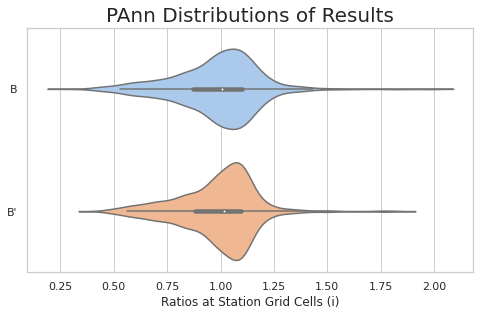

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 161.33423504268254 
UAA_station_mean 120.0 
Combined 140.66711752134125


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: mm


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)